<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Expected_Cross_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- Import Libraries ---
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- Load Data ---
file_path = '/content/drive/MyDrive/Recruitment/Brøndby 1-1 Nordsjælland.csv'  # Change if needed
df = pd.read_csv(file_path)

# Add event time
df['eventTime'] = df['timeMin'] * 60 + df['timeSec']

# --- Step 1: Identify Passes and Crosses ---
passes = df[df['typeId'] == 1].copy()

def has_qualifier(row, q_id):
    for i in range(20):
        q_col = f'qualifier/{i}/qualifierId'
        if q_col in row and row[q_col] == q_id:
            return True
    return False

def get_qualifier_value(row, q_id):
    for i in range(20):
        q_id_col = f'qualifier/{i}/qualifierId'
        q_val_col = f'qualifier/{i}/value'
        if q_id_col in row and row[q_id_col] == q_id:
            return float(row[q_val_col]) if pd.notnull(row[q_val_col]) else None
    return None

# Label crosses, assists, key passes
passes['isCross'] = passes.apply(lambda r: has_qualifier(r, 2), axis=1)
passes['endX'] = passes.apply(lambda r: get_qualifier_value(r, 140), axis=1)
passes['endY'] = passes.apply(lambda r: get_qualifier_value(r, 141), axis=1)
passes['isAssist'] = passes.apply(lambda r: has_qualifier(r, 210), axis=1)
passes['isSecondAssist'] = passes.apply(lambda r: has_qualifier(r, 218), axis=1)

# Key pass detection
shots = df[df['typeId'].isin([13, 14, 15, 16])].copy()
shots['eventTime'] = shots['timeMin'] * 60 + shots['timeSec']

def find_key_pass(row):
    future = shots[(shots['periodId'] == row['periodId']) & (shots['eventTime'] > row['eventTime'])]
    if not future.empty:
        return future.iloc[0]['typeId']
    return None

passes['linkedShotTypeId'] = passes.apply(find_key_pass, axis=1)
passes['isKeyPass'] = passes['linkedShotTypeId'].isin([13, 14, 15])

# --- Step 2: Filter Crosses ---
crosses = passes[passes['isCross']].copy()

# Merge outcome and time data safely
for col in ['outcome', 'periodId', 'timeMin', 'timeSec']:
    if col in crosses.columns:
        crosses = crosses.drop(columns=[col])
crosses = crosses.merge(
    passes[['id', 'outcome', 'periodId', 'timeMin', 'timeSec']],
    on='id', how='left'
)
crosses['outcome'] = pd.to_numeric(crosses['outcome'], errors='coerce').fillna(0).astype(int)

# --- Step 3: Geometry-Based xC ---
GOAL_X, GOAL_Y, GOAL_WIDTH = 100, 50, 7.32
MAX_DIST = np.sqrt(100**2 + 50**2)

def calculate_distance(x, y):
    return np.sqrt((GOAL_X - x)**2 + (GOAL_Y - y)**2)

def calculate_angle(x, y):
    b = GOAL_X - x
    if b <= 0:
        return 0
    angle = np.arctan((GOAL_WIDTH * 0.5) / b)
    return angle * 2

crosses['distanceToGoal'] = crosses.apply(lambda r: calculate_distance(r['endX'], r['endY']), axis=1)
crosses['angleToGoal'] = crosses.apply(lambda r: calculate_angle(r['endX'], r['endY']), axis=1)
crosses['angleScore'] = crosses['angleToGoal'] / np.pi
crosses['distanceScore'] = 1 - (crosses['distanceToGoal'] / MAX_DIST)
crosses['eventBonus'] = 0
crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
crosses.loc[crosses['isAssist'], 'eventBonus'] += 0.30
crosses['successBonus'] = crosses['outcome'].apply(lambda x: 0.2 if x == 1 else 0)

# Zone/Depth Features
def cross_zone(x, y):
    if y < 33: return 'Right Wing'
    elif y > 67: return 'Left Wing'
    return 'Central'

crosses['crossZone'] = crosses.apply(lambda r: cross_zone(r['x'], r['y']), axis=1)
crosses['deepCross'] = crosses['x'] < 70
crosses['zoneBonus'] = crosses['crossZone'].map({'Left Wing': 0.1, 'Right Wing': 0.1, 'Central': 0.0})
crosses['depthBonus'] = crosses['deepCross'].apply(lambda x: -0.05 if x else 0.05)

# --- Step 4: Defensive Context Features ---
crosses['boxPressureCount'] = 0
crosses['oppPPDA'] = 0.0
crosses['oppDefActionHeight'] = 0.0
crosses['oppClearanceSuccess'] = 0.0

df['eventTime'] = df['timeMin'] * 60 + df['timeSec']
for idx, row in tqdm(crosses.iterrows(), total=len(crosses)):
    attacking_team = row['contestantId']
    period = row['periodId']
    time = row['timeMin'] * 60 + row['timeSec']
    opponent_team = [t for t in df['contestantId'].unique() if t != attacking_team][0]

    box_events = df[
        (df['contestantId'] == opponent_team) &
        (df['periodId'] == period) &
        (df['eventTime'] >= time) &
        (df['x'] > 85) & (df['y'] > 20) & (df['y'] < 80) &
        (df['typeId'].isin([4, 12, 44]))
    ]

    def_actions = df[(df['contestantId'] == opponent_team) & (df['typeId'].isin([4, 44, 5]))]
    passes_att = df[(df['contestantId'] == attacking_team) & (df['typeId'] == 1)]
    ppda = len(passes_att) / (len(def_actions) + 1e-5)

    opp_def_x = df[(df['contestantId'] == opponent_team) & (df['typeId'].isin([4, 5, 12]))]['x'].mean()
    clearances = df[(df['contestantId'] == opponent_team) & (df['typeId'] == 12)]
    clearance_success = clearances['outcome'].sum() / len(clearances) if len(clearances) > 0 else 0

    crosses.at[idx, 'boxPressureCount'] = len(box_events)
    crosses.at[idx, 'oppPPDA'] = ppda
    crosses.at[idx, 'oppDefActionHeight'] = opp_def_x
    crosses.at[idx, 'oppClearanceSuccess'] = clearance_success

# --- Step 5: Final xC Calculation ---
crosses['xC_final'] = (
    0.3 * crosses['angleScore'] +
    0.3 * crosses['distanceScore'] +
    0.15 * crosses['eventBonus'] +
    0.1 * crosses['successBonus'] +
    0.1 * crosses['zoneBonus'] +
    0.05 * crosses['depthBonus'] +
    -0.02 * crosses['boxPressureCount'] +
    0.05 * (crosses['oppPPDA'] > 12).astype(int) +
    -0.03 * (crosses['oppDefActionHeight'] - 40) +
    -0.1 * (1 - crosses['oppClearanceSuccess'])
)

# --- Step 6: Export ---
output_path = '/content/drive/MyDrive/Recruitment/enhanced_crosses_xC_final.xlsx'
crosses.to_excel(output_path, index=False)
print(f"✅ File saved: {output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-11-53f8e0a3bc6a>:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
100%|██████████| 27/27 [00:00<00:00, 189.38it/s]


✅ File saved: /content/drive/MyDrive/Recruitment/enhanced_crosses_xC_final.xlsx


In [18]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# --- Settings ---
folder_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025/'
output_file = '/content/drive/MyDrive/Outswinger FC/player_cross_summary.xlsx'

# --- Helper Functions ---
def has_qualifier(row, q_id):
    for i in range(20):
        q_col = f'qualifier/{i}/qualifierId'
        if q_col in row and row[q_col] == q_id:
            return True
    return False

def get_qualifier_value(row, q_id):
    for i in range(20):
        q_id_col = f'qualifier/{i}/qualifierId'
        q_val_col = f'qualifier/{i}/value'
        if q_id_col in row and row[q_id_col] == q_id:
            return float(row[q_val_col]) if pd.notnull(row[q_val_col]) else None
    return None

def calculate_distance(x, y):
    return np.sqrt((100 - x)**2 + (50 - y)**2)

def calculate_angle(x, y):
    b = 100 - x
    if b <= 0:
        return 0
    return np.arctan(7.32 * 0.5 / b) * 2

# --- Store all crosses ---
all_crosses = []

# --- Process Each File ---
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        df['eventTime'] = df['timeMin'] * 60 + df['timeSec']

        passes = df[df['typeId'] == 1].copy()
        passes['isCross'] = passes.apply(lambda r: has_qualifier(r, 2), axis=1)
        passes['endX'] = passes.apply(lambda r: get_qualifier_value(r, 140), axis=1)
        passes['endY'] = passes.apply(lambda r: get_qualifier_value(r, 141), axis=1)
        passes['isAssist'] = passes.apply(lambda r: has_qualifier(r, 210), axis=1)
        passes['isSecondAssist'] = passes.apply(lambda r: has_qualifier(r, 218), axis=1)

        shots = df[df['typeId'].isin([13, 14, 15, 16])].copy()
        shots['eventTime'] = shots['timeMin'] * 60 + shots['timeSec']

        def find_key_pass(row):
            future = shots[(shots['periodId'] == row['periodId']) & (shots['eventTime'] > row['eventTime'])]
            if not future.empty:
                return future.iloc[0]['typeId']
            return None

        passes['linkedShotTypeId'] = passes.apply(find_key_pass, axis=1)
        passes['isKeyPass'] = passes['linkedShotTypeId'].isin([13, 14, 15])

        crosses = passes[passes['isCross']].copy()
        for col in ['outcome', 'periodId', 'timeMin', 'timeSec']:
            if col in crosses.columns:
                crosses = crosses.drop(columns=[col])
        crosses = crosses.merge(passes[['id', 'outcome', 'periodId', 'timeMin', 'timeSec']], on='id', how='left')
        crosses['outcome'] = pd.to_numeric(crosses['outcome'], errors='coerce').fillna(0).astype(int)

        crosses['distanceToGoal'] = crosses.apply(lambda r: calculate_distance(r['endX'], r['endY']), axis=1)
        crosses['angleToGoal'] = crosses.apply(lambda r: calculate_angle(r['endX'], r['endY']), axis=1)
        crosses['angleScore'] = crosses['angleToGoal'] / np.pi
        crosses['distanceScore'] = 1 - (crosses['distanceToGoal'] / np.sqrt(100**2 + 50**2))
        crosses['eventBonus'] = 0
        crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
        crosses.loc[crosses['isAssist'], 'eventBonus'] += 0.30
        crosses['successBonus'] = crosses['outcome'].apply(lambda x: 0.2 if x == 1 else 0)

        def cross_zone(x, y):
            if y < 33: return 'Right Wing'
            elif y > 67: return 'Left Wing'
            return 'Central'

        crosses['crossZone'] = crosses.apply(lambda r: cross_zone(r['x'], r['y']), axis=1)
        crosses['deepCross'] = crosses['x'] < 70
        crosses['zoneBonus'] = crosses['crossZone'].map({'Left Wing': 0.1, 'Right Wing': 0.1, 'Central': 0.0})
        crosses['depthBonus'] = crosses['deepCross'].apply(lambda x: -0.05 if x else 0.05)

        df['eventTime'] = df['timeMin'] * 60 + df['timeSec']
        crosses['boxPressureCount'] = 0
        crosses['oppPPDA'] = 0.0
        crosses['oppDefActionHeight'] = 0.0
        crosses['oppClearanceSuccess'] = 0.0

        for idx, row in crosses.iterrows():
            attacking_team = row['contestantId']
            period = row['periodId']
            time = row['timeMin'] * 60 + row['timeSec']
            teams = df['contestantId'].dropna().unique()
            opponent_team = [t for t in teams if t != attacking_team]
            if not opponent_team:
                continue
            opponent_team = opponent_team[0]

            box_events = df[
                (df['contestantId'] == opponent_team) &
                (df['periodId'] == period) &
                (df['eventTime'] >= time) &
                (df['x'] > 85) & (df['y'] > 20) & (df['y'] < 80) &
                (df['typeId'].isin([4, 12, 44]))
            ]

            def_actions = df[(df['contestantId'] == opponent_team) & (df['typeId'].isin([4, 44, 5]))]
            passes_att = df[(df['contestantId'] == attacking_team) & (df['typeId'] == 1)]
            ppda = len(passes_att) / (len(def_actions) + 1e-5)
            opp_def_x = df[(df['contestantId'] == opponent_team) & (df['typeId'].isin([4, 5, 12]))]['x'].mean()
            clearances = df[(df['contestantId'] == opponent_team) & (df['typeId'] == 12)]
            clearance_success = clearances['outcome'].sum() / len(clearances) if len(clearances) > 0 else 0

            crosses.at[idx, 'boxPressureCount'] = len(box_events)
            crosses.at[idx, 'oppPPDA'] = ppda
            crosses.at[idx, 'oppDefActionHeight'] = opp_def_x
            crosses.at[idx, 'oppClearanceSuccess'] = clearance_success

        # Final xC
        crosses['xC_final'] = (
            0.3 * crosses['angleScore'] +
            0.3 * crosses['distanceScore'] +
            0.15 * crosses['eventBonus'] +
            0.1 * crosses['successBonus'] +
            0.1 * crosses['zoneBonus'] +
            0.05 * crosses['depthBonus'] +
            -0.02 * crosses['boxPressureCount'] +
            0.05 * (crosses['oppPPDA'] > 12).astype(int) +
            -0.03 * (crosses['oppDefActionHeight'] - 40) +
            -0.1 * (1 - crosses['oppClearanceSuccess'])
        )

        all_crosses.append(crosses)

# --- Combine All Crosses ---
all_crosses_df = pd.concat(all_crosses, ignore_index=True)

# --- Player Summary ---
summary = all_crosses_df.groupby(['playerName', 'contestantId']).agg(
    num_crosses=('id', 'count'),
    num_assists=('isAssist', 'sum'),
    num_key_passes=('isKeyPass', 'sum'),
    avg_xC=('xC_final', 'mean')
).reset_index()

# --- Export Summary ---
summary.to_excel(output_file, index=False)
print(f"✅ Player summary saved: {output_file}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-18-04112a5f0c15>:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
<ipython-input-18-04112a5f0c15>:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
<ipython-input-18-04112a5f0c15>:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futur

✅ Player summary saved: /content/drive/MyDrive/Outswinger FC/player_cross_summary.xlsx


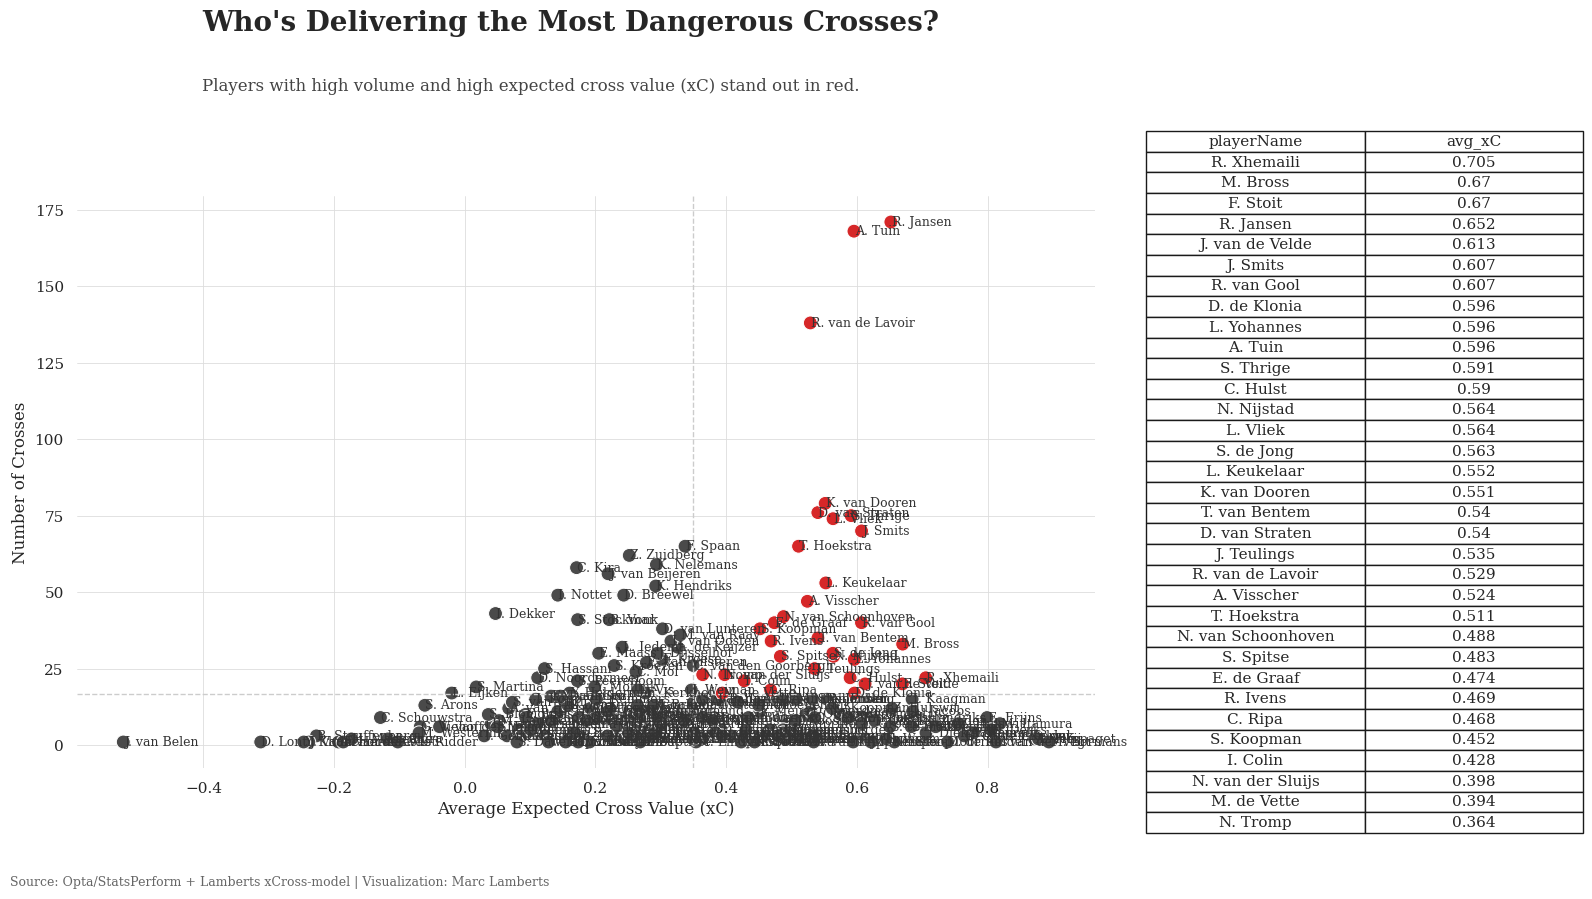

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate averages
mean_xC = summary['avg_xC'].mean()
mean_crosses = summary['num_crosses'].mean()

# Identify outliers
summary['is_outlier'] = (summary['avg_xC'] > mean_xC) & (summary['num_crosses'] > mean_crosses)
outliers = summary[summary['is_outlier']].sort_values(by='avg_xC', ascending=False)

# --- Layout ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), gridspec_kw={'width_ratios': [2.8, 1]})
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Serif'

# --- Scatterplot (Left) ---
palette = {True: "#d62728", False: "#4a4a4a"}
sns.scatterplot(
    data=summary,
    x='avg_xC',
    y='num_crosses',
    hue='is_outlier',
    palette=palette,
    legend=False,
    s=100,
    edgecolor='white',
    linewidth=0.7,
    ax=ax1
)

# Add player name labels
for _, row in summary.iterrows():
    ax1.text(
        row['avg_xC'] + 0.001,
        row['num_crosses'],
        row['playerName'],
        fontsize=9,
        ha='left',
        va='center',
        color='#333333'
    )

# Average lines
ax1.axhline(mean_crosses, color='#cccccc', linestyle='--', linewidth=1)
ax1.axvline(mean_xC, color='#cccccc', linestyle='--', linewidth=1)

# Axis labels and style
ax1.set_xlabel("Average Expected Cross Value (xC)", fontsize=12)
ax1.set_ylabel("Number of Crosses", fontsize=12)
ax1.grid(color='#dddddd', linewidth=0.6)
sns.despine(left=True, bottom=True, ax=ax1)

# --- Title and Subtitle ---
fig.suptitle("Who's Delivering the Most Dangerous Crosses?", fontsize=20, weight='bold', x=0.13, ha='left')
fig.text(
    0.13, 0.89,
    "Players with high volume and high expected cross value (xC) stand out in red.",
    fontsize=12, ha='left', color='#444444'
)


# --- Table of Outliers (Right) ---
ax2.axis('off')
table_data = outliers[['playerName', 'avg_xC']].copy().round({'avg_xC': 3})

table = ax2.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    cellLoc='center',
    colLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

# --- Source Footer ---
fig.text(0.01, 0.01, "Source: Opta/StatsPerform + Lamberts xCross-model | Visualization: Marc Lamberts",
         ha='left', va='center', fontsize=9, color='#666666')

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()


In [37]:
import pandas as pd
from scipy.spatial.distance import euclidean

# --- 1. High-xC, Low-Assist Finder ---
summary['assist_rate'] = summary['num_assists'] / summary['num_crosses']
summary['assist_gap'] = summary['avg_xC'] - summary['assist_rate']

undervalued_creators = summary.sort_values(by='assist_gap', ascending=False).copy()
undervalued_creators = undervalued_creators[['playerName', 'avg_xC', 'num_crosses', 'num_assists', 'assist_rate', 'assist_gap']]

# --- 2. Cross Style Match Model ---

# Step 1: Aggregate cross style features
cross_features = crosses.groupby('playerName').agg({
    'x': 'mean',
    'y': 'mean',
    'endX': 'mean',
    'endY': 'mean',
    'deepCross': 'mean'
}).rename(columns={
    'x': 'avg_startX',
    'y': 'avg_startY',
    'endX': 'avg_endX',
    'endY': 'avg_endY',
    'deepCross': 'deep_cross_ratio'
})

# Step 2: Add central_cross_ratio manually
cross_features['central_cross_ratio'] = crosses.groupby('playerName')['y'].apply(
    lambda y: ((y >= 33) & (y <= 67)).mean()
)
cross_features = cross_features.reset_index()

# Step 3: Merge into player summary
style_summary = summary.merge(cross_features, on='playerName', how='left')

# Step 4: Define your club’s preferred cross style
club_style = {
    'avg_startX': 75,
    'avg_startY': 80,
    'avg_endX': 90,
    'avg_endY': 50,
    'deep_cross_ratio': 0.4,
    'central_cross_ratio': 0.1
}
features = ['avg_startX', 'avg_startY', 'avg_endX', 'avg_endY', 'deep_cross_ratio', 'central_cross_ratio']

# Step 5: Drop rows with NaNs in required style features
style_summary = style_summary.dropna(subset=features)

# Step 6: Compute Euclidean distance to club profile
style_summary['style_distance'] = style_summary[features].apply(
    lambda row: euclidean(row.values, [club_style[f] for f in features]), axis=1
)

style_match = style_summary.sort_values(by='style_distance').copy()
style_match = style_match[['playerName', 'avg_xC', 'style_distance'] + features]

# --- 3. Cross-Heavy Fullback Recommender ---
if 'position' in summary.columns:
    cross_fb = summary[
        (summary['position'].str.lower() == 'fullback') &
        (summary['num_crosses'] > 15) &
        (summary['avg_xC'] > summary['avg_xC'].median())
    ].sort_values(by='avg_xC', ascending=False).copy()
    cross_fb = cross_fb[['playerName', 'position', 'num_crosses', 'avg_xC']]
else:
    cross_fb = pd.DataFrame(columns=['playerName', 'position', 'num_crosses', 'avg_xC'])  # fallback

# --- 4. Export All to Excel ---
output_path = '/content/drive/MyDrive/Recruitment/scouting_shortlists.xlsx'

with pd.ExcelWriter(output_path) as writer:
    undervalued_creators.to_excel(writer, sheet_name='High_xC_Low_Assist', index=False)
    style_match.to_excel(writer, sheet_name='Style_Match', index=False)
    cross_fb.to_excel(writer, sheet_name='Cross_Heavy_Fullbacks', index=False)

print(f"✅ Scouting shortlists saved to: {output_path}")


✅ Scouting shortlists saved to: /content/drive/MyDrive/Recruitment/scouting_shortlists.xlsx


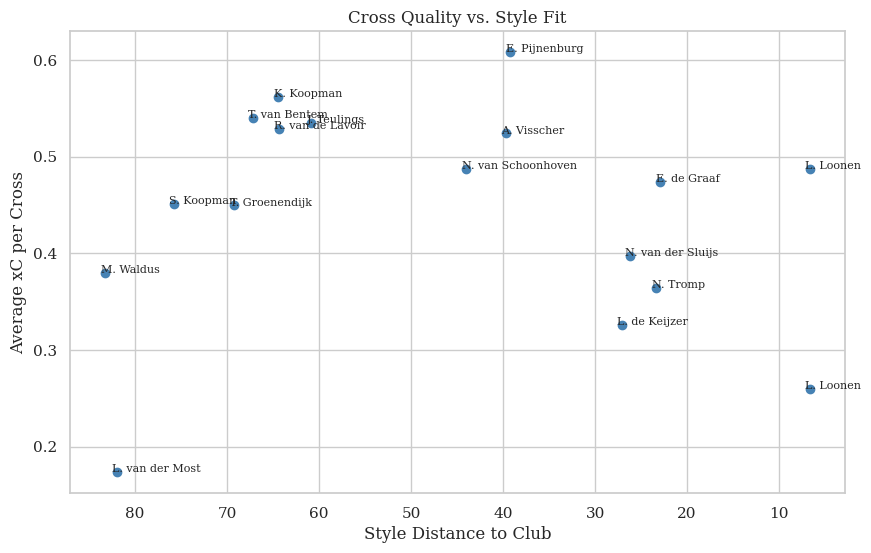

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Load specific sheet from Excel
file_path = '/content/drive/MyDrive/Recruitment/scouting_shortlists.xlsx'
df = pd.read_excel(file_path, sheet_name='Style_Match')  # 👈 specify sheet

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['style_distance'], df['avg_xC'], c='steelblue')

# Add player labels
for _, row in df.iterrows():
    plt.text(row['style_distance'] + 0.5, row['avg_xC'], row['playerName'], fontsize=8)
    plt.gca().invert_xaxis()


plt.xlabel("Style Distance to Club")
plt.ylabel("Average xC per Cross")
plt.title("Cross Quality vs. Style Fit")
plt.grid(True)
plt.show()


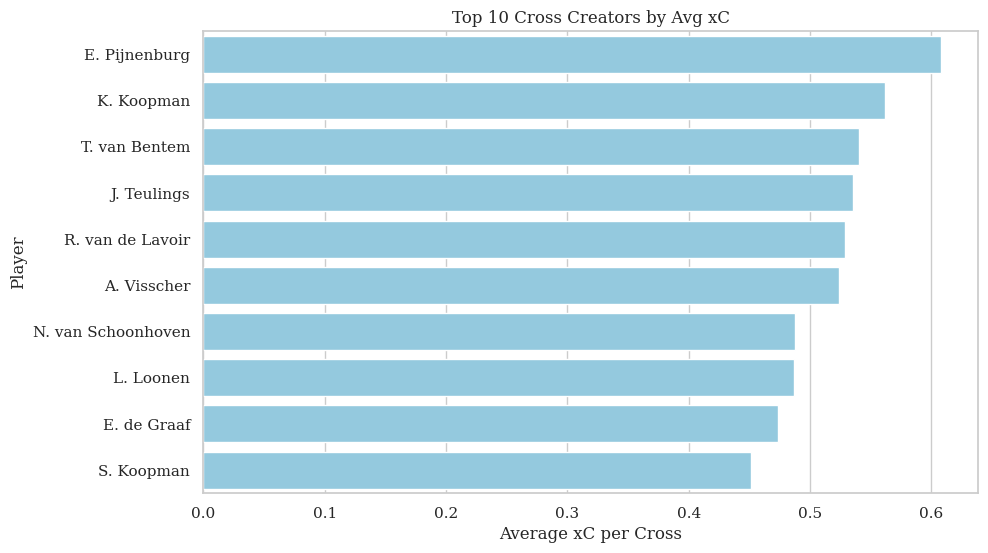

In [43]:
top_xc = df.sort_values(by='avg_xC', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_xc, y='playerName', x='avg_xC', color='skyblue')
plt.xlabel("Average xC per Cross")
plt.ylabel("Player")
plt.title("Top 10 Cross Creators by Avg xC")
plt.grid(True, axis='x')
plt.show()


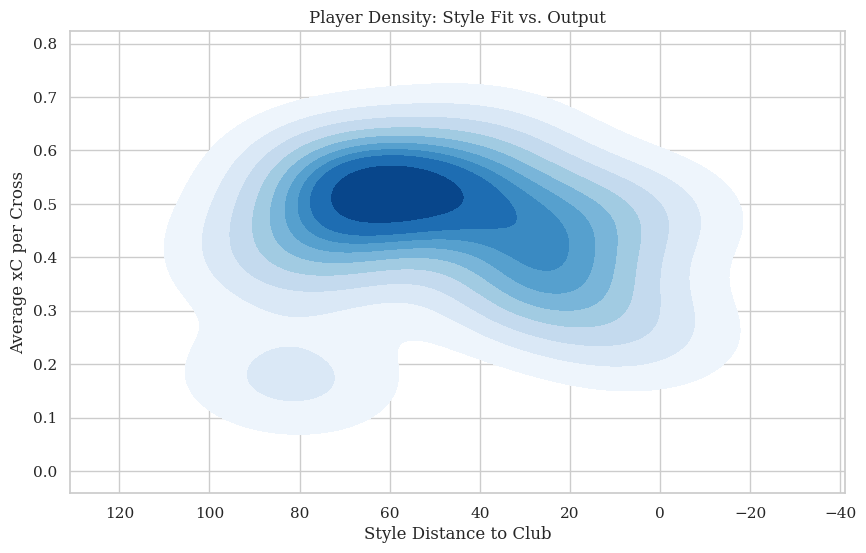

In [44]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='style_distance', y='avg_xC', fill=True, cmap='Blues')
plt.xlabel("Style Distance to Club")
plt.ylabel("Average xC per Cross")
plt.title("Player Density: Style Fit vs. Output")
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()


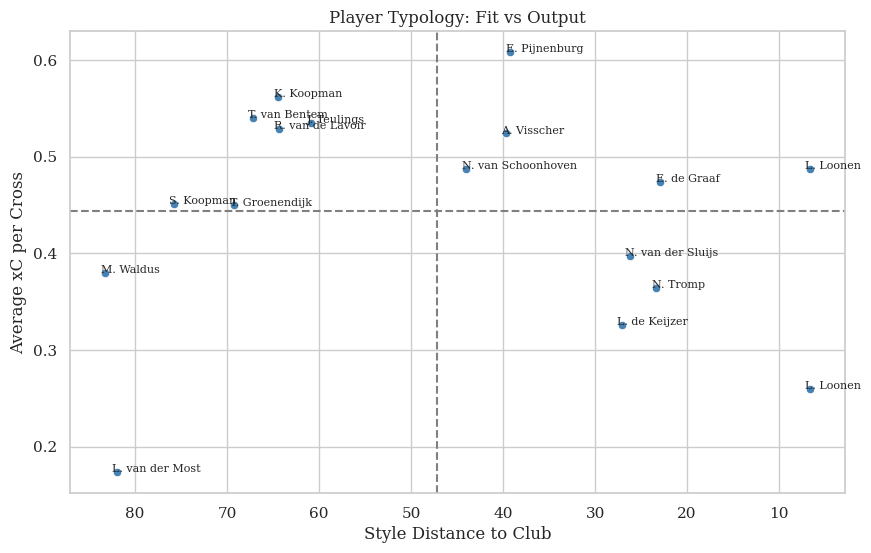

In [45]:
mean_xC = df['avg_xC'].mean()
mean_dist = df['style_distance'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='style_distance', y='avg_xC', color='steelblue')

# Labels
for _, row in df.iterrows():
    plt.text(row['style_distance'] + 0.5, row['avg_xC'], row['playerName'], fontsize=8)

# Quadrants
plt.axvline(mean_dist, linestyle='--', color='gray')
plt.axhline(mean_xC, linestyle='--', color='gray')

# Axis
plt.gca().invert_xaxis()
plt.xlabel("Style Distance to Club")
plt.ylabel("Average xC per Cross")
plt.title("Player Typology: Fit vs Output")
plt.grid(True)
plt.show()


<ipython-input-46-9fc2cb4cc15d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(


Text(0.5, 0.98, 'Cross Quality by Player Tier')

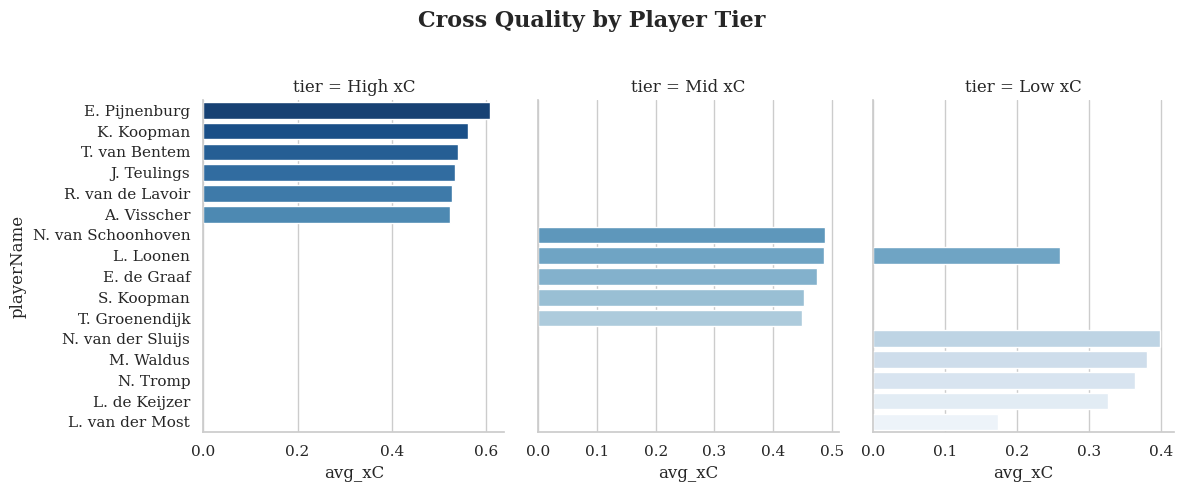

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create tiers based on xC
df['tier'] = pd.qcut(df['avg_xC'], q=3, labels=['Low xC', 'Mid xC', 'High xC'])

# Plot end location heat per tier
sns.catplot(
    data=df.sort_values('avg_xC', ascending=False),
    kind="bar",
    x="avg_xC",
    y="playerName",
    col="tier",
    col_order=["High xC", "Mid xC", "Low xC"],
    height=5, aspect=0.8, palette="Blues_r", sharex=False
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Cross Quality by Player Tier", fontsize=16, fontweight='bold')


<ipython-input-47-041c32f7e422>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='tier', y='style_distance', palette='coolwarm')


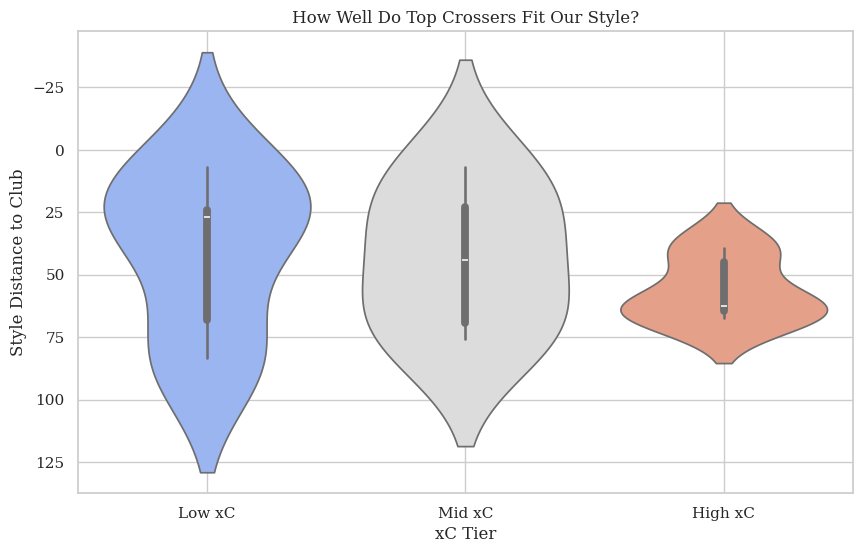

In [47]:
sns.violinplot(data=df, x='tier', y='style_distance', palette='coolwarm')
plt.xlabel("xC Tier")
plt.ylabel("Style Distance to Club")
plt.title("How Well Do Top Crossers Fit Our Style?")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


<ipython-input-48-6461e225052e>:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index='startY_bin', columns='startX_bin', values='avg_xC', aggfunc='mean')


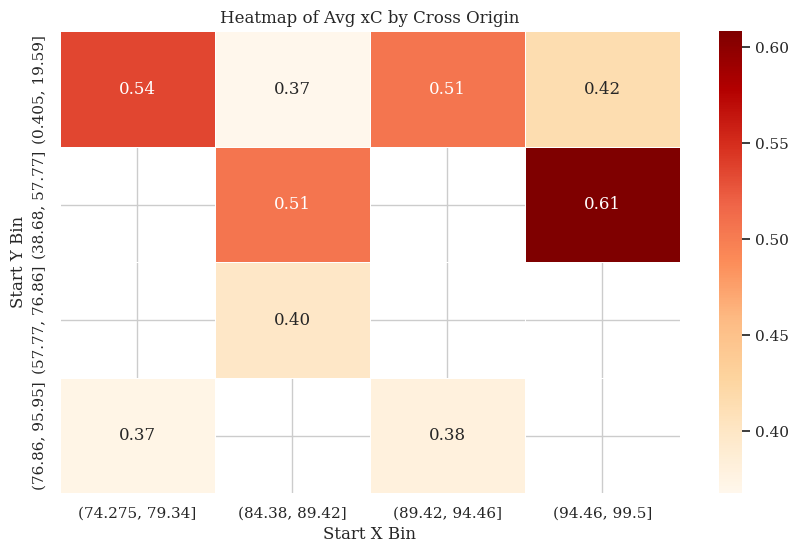

In [48]:
df['startX_bin'] = pd.cut(df['avg_startX'], bins=5)
df['startY_bin'] = pd.cut(df['avg_startY'], bins=5)

pivot = df.pivot_table(index='startY_bin', columns='startX_bin', values='avg_xC', aggfunc='mean')
sns.heatmap(pivot, cmap='OrRd', linewidths=0.5, annot=True, fmt=".2f")

plt.title("Heatmap of Avg xC by Cross Origin")
plt.xlabel("Start X Bin")
plt.ylabel("Start Y Bin")
plt.show()


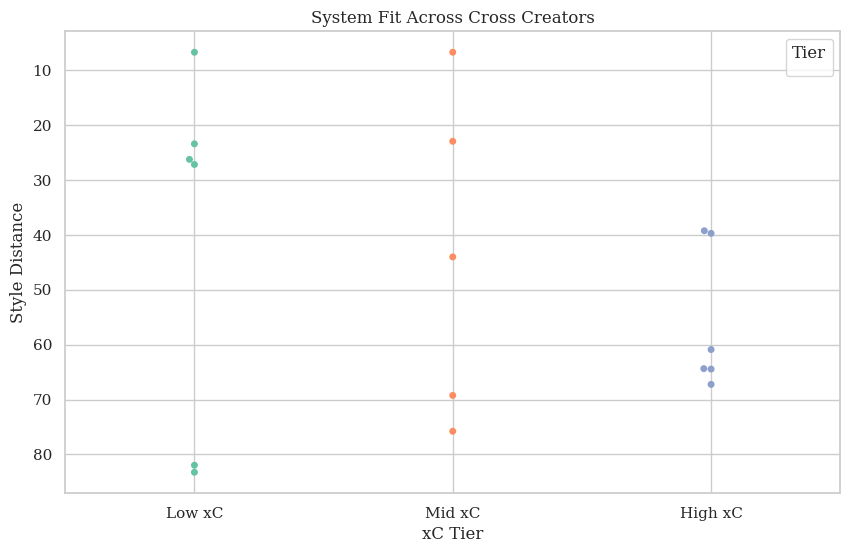

In [49]:
sns.swarmplot(data=df, x='tier', y='style_distance', hue='tier', palette='Set2')
plt.gca().invert_yaxis()
plt.title("System Fit Across Cross Creators")
plt.xlabel("xC Tier")
plt.ylabel("Style Distance")
plt.grid(True)
plt.legend(title='Tier')
plt.show()


<ipython-input-53-48b127030e9d>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_xc = df.groupby('zone')['avg_xC'].mean().reset_index()
<ipython-input-53-48b127030e9d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=zone_xc, x='zone', y='avg_xC', palette='pastel')


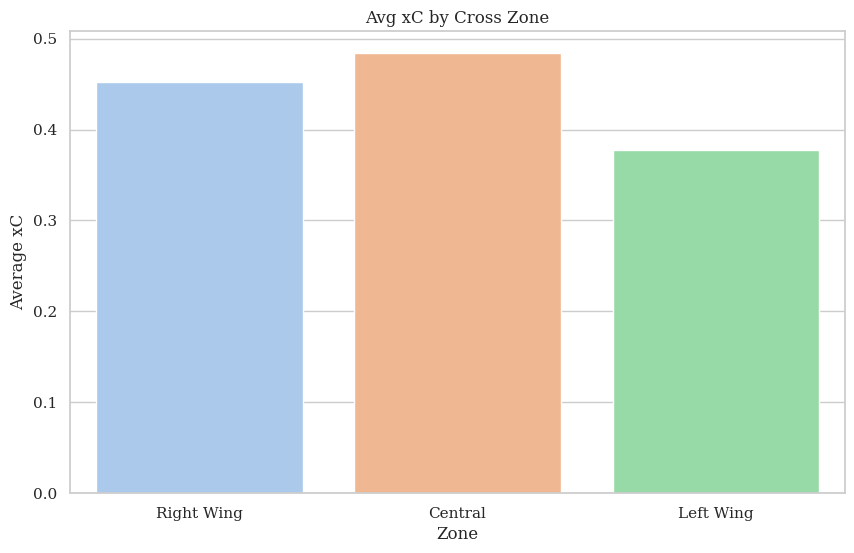

In [53]:
df['zone'] = pd.cut(df['avg_startY'], bins=[0, 33, 67, 100], labels=['Right Wing', 'Central', 'Left Wing'])

zone_xc = df.groupby('zone')['avg_xC'].mean().reset_index()
sns.barplot(data=zone_xc, x='zone', y='avg_xC', palette='pastel')
plt.title("Avg xC by Cross Zone")
plt.ylabel("Average xC")
plt.xlabel("Zone")
plt.show()


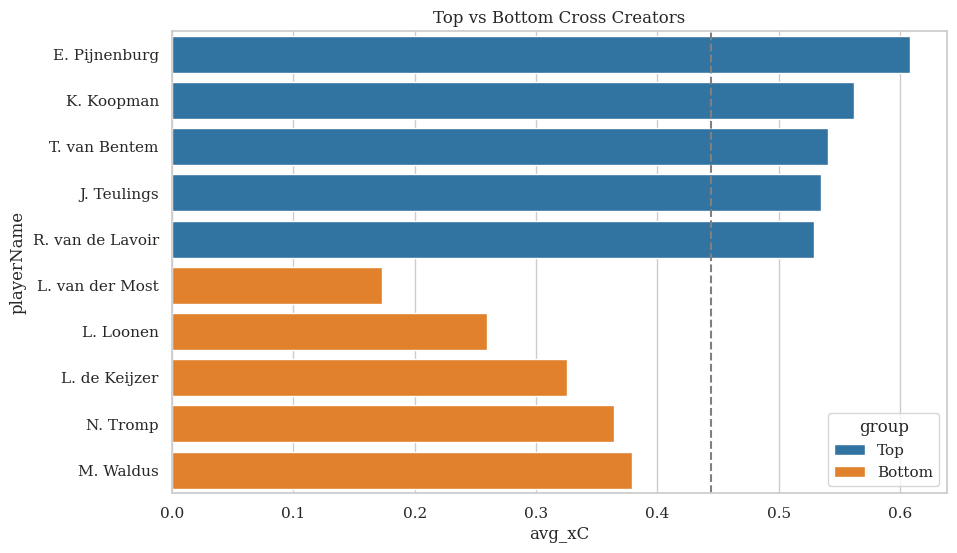

In [54]:
top = df.sort_values('avg_xC', ascending=False).head(5)
bottom = df.sort_values('avg_xC').head(5)

mirror = pd.concat([top, bottom])
mirror['group'] = ['Top']*5 + ['Bottom']*5

sns.barplot(data=mirror, y='playerName', x='avg_xC', hue='group', dodge=False, palette=['#1f77b4', '#ff7f0e'])
plt.axvline(df['avg_xC'].mean(), color='gray', linestyle='--')
plt.title("Top vs Bottom Cross Creators")
plt.show()


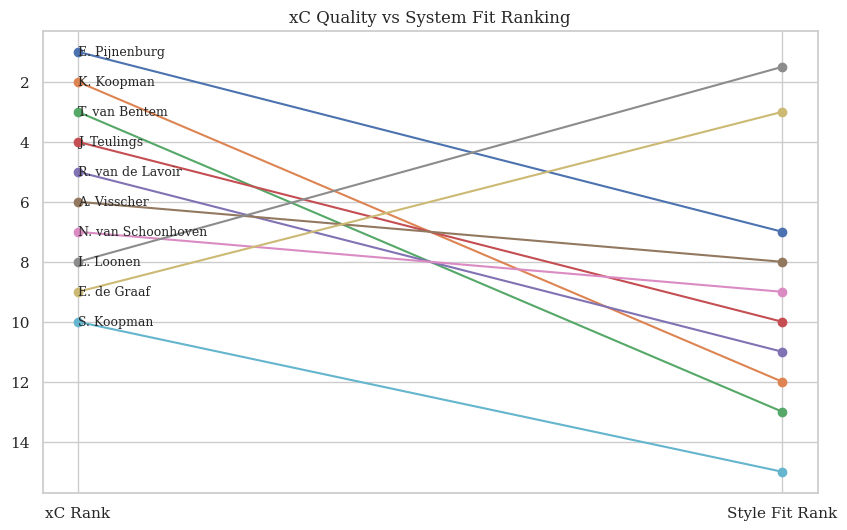

In [55]:
df['xC_rank'] = df['avg_xC'].rank(ascending=False)
df['style_rank'] = df['style_distance'].rank(ascending=True)

df_top = df.sort_values('avg_xC', ascending=False).head(10)

for _, row in df_top.iterrows():
    plt.plot([0, 1], [row['xC_rank'], row['style_rank']], marker='o')
    plt.text(0, row['xC_rank'], row['playerName'], va='center', fontsize=9)

plt.xticks([0, 1], ['xC Rank', 'Style Fit Rank'])
plt.title("xC Quality vs System Fit Ranking")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


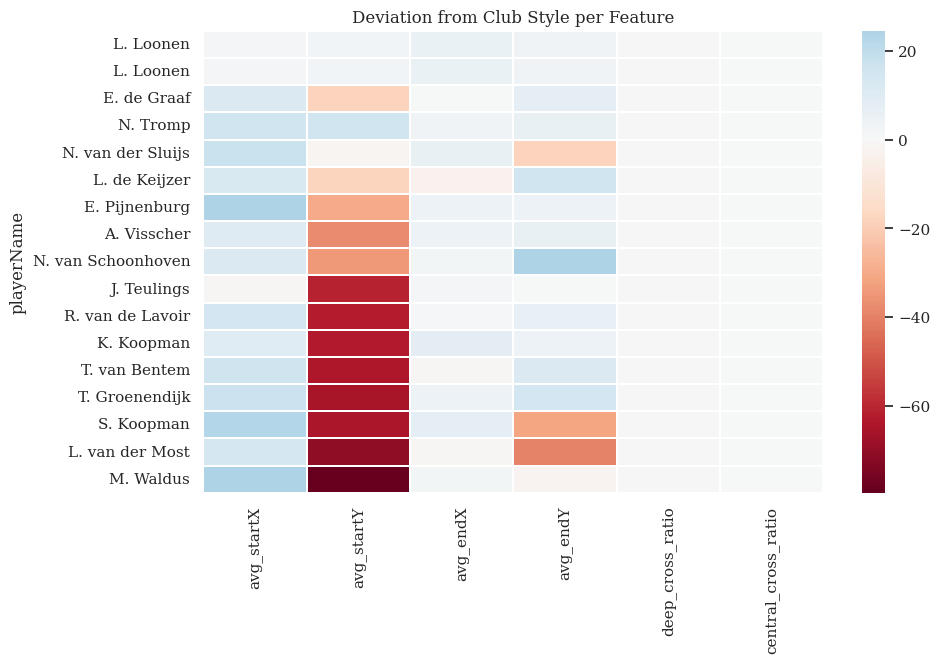

In [57]:
diff_df = df.copy()
for col in ['avg_startX', 'avg_startY', 'avg_endX', 'avg_endY', 'deep_cross_ratio', 'central_cross_ratio']:
    diff_df[col] = df[col] - club_style[col]

sns.heatmap(
    diff_df.set_index('playerName')[list(club_style.keys())].fillna(0),
    cmap='RdBu', center=0, annot=False, linewidths=0.3
)
plt.title("Deviation from Club Style per Feature")
plt.show()


In [58]:
import pandas as pd
import numpy as np

file_path = '/content/drive/MyDrive/Recruitment/scouting_shortlists.xlsx'
df = pd.read_excel(file_path, sheet_name='High_xC_Low_Assist')  # 👈 specify sheet

# --- STEP 1: Base Metrics ---
df['assist_rate'] = df['num_assists'] / df['num_crosses'].replace(0, np.nan)
df['assist_rate'] = df['assist_rate'].fillna(0)

df['assist_gap'] = df['avg_xC'] - df['assist_rate']

df['xC_volume'] = df['avg_xC'] * df['num_crosses']

df['efficiency'] = df['num_assists'] / df['xC_volume'].replace(0, np.nan)
df['efficiency'] = df['efficiency'].fillna(0)

# --- STEP 2: Flag Undervalued Crossers ---
df['undervalued'] = (df['assist_gap'] > 0.3) & (df['avg_xC'] > df['avg_xC'].mean())

# --- STEP 3: Segment Players by Tiers ---
def classify_tier(row):
    if row['avg_xC'] > df['avg_xC'].quantile(0.75) and row['assist_rate'] > df['assist_rate'].quantile(0.75):
        return 'Elite (Tier 1)'
    elif row['avg_xC'] > df['avg_xC'].quantile(0.75) and row['assist_rate'] < df['assist_rate'].quantile(0.25):
        return 'Undervalued (Tier 2)'
    elif row['avg_xC'] < df['avg_xC'].quantile(0.25) and row['assist_rate'] > df['assist_rate'].quantile(0.75):
        return 'Overperformer (Tier 3)'
    else:
        return 'Other (Tier 4)'

df['tier'] = df.apply(classify_tier, axis=1)

# --- STEP 4: Format Key Columns ---
df = df.round({
    'avg_xC': 3,
    'assist_rate': 3,
    'assist_gap': 3,
    'xC_volume': 1,
    'efficiency': 3
})

# --- STEP 5: Sort by Undervalued First ---
df_sorted = df.sort_values(by='assist_gap', ascending=False)

# --- Optional Export ---
output_path = '/content/drive/MyDrive/Recruitment/crossing_metrics_enriched.xlsx'
df_sorted.to_excel(output_path, index=False)
print(f"✅ Metrics saved to: {output_path}")

# Preview top rows
df_sorted[['playerName', 'avg_xC', 'num_crosses', 'num_assists', 'assist_rate', 'assist_gap', 'efficiency', 'tier']].head(10)


✅ Metrics saved to: /content/drive/MyDrive/Recruitment/crossing_metrics_enriched.xlsx


,playerName,avg_xC,num_crosses,num_assists,assist_rate,assist_gap,efficiency,tier
0,M. Bormans,0.894,1,0,0.0,0.894,0.0,Other (Tier 4)
1,L. Heij,0.878,2,0,0.0,0.878,0.0,Other (Tier 4)
2,M. Itamura,0.819,7,0,0.0,0.819,0.0,Other (Tier 4)
3,I. van der Vegt,0.813,1,0,0.0,0.813,0.0,Other (Tier 4)
4,R. Derks,0.805,5,0,0.0,0.805,0.0,Other (Tier 4)
5,F. Kalma,0.779,4,0,0.0,0.779,0.0,Other (Tier 4)
6,G. op den Kelder,0.764,3,0,0.0,0.764,0.0,Other (Tier 4)
7,Z. Hulswit,0.755,7,0,0.0,0.755,0.0,Other (Tier 4)
8,D. de Ridder,0.739,1,0,0.0,0.739,0.0,Other (Tier 4)
9,J. Diekman,0.706,4,0,0.0,0.706,0.0,Other (Tier 4)


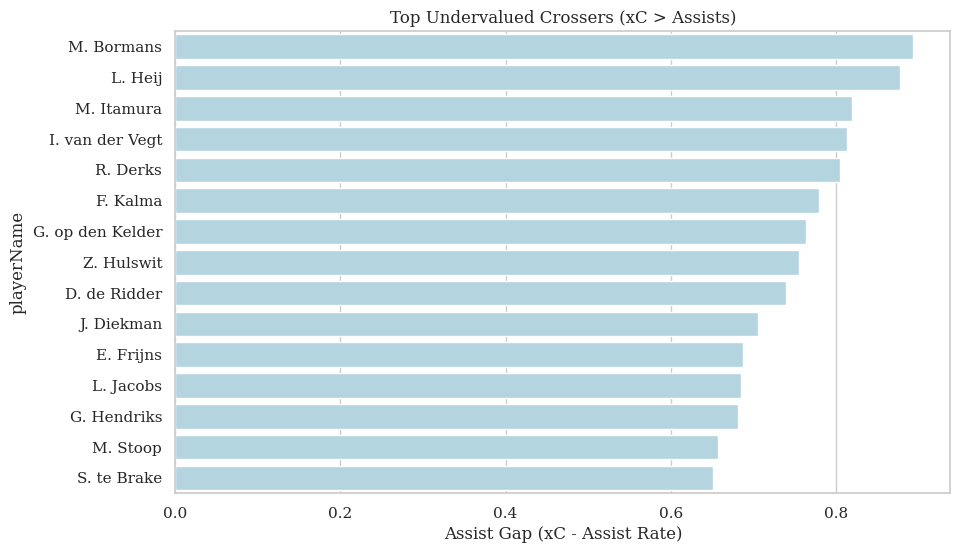

In [59]:
top_gap = df.sort_values(by='assist_gap', ascending=False).head(15)
sns.barplot(data=top_gap, x='assist_gap', y='playerName', color='lightblue')
plt.title("Top Undervalued Crossers (xC > Assists)")
plt.xlabel("Assist Gap (xC - Assist Rate)")
plt.show()


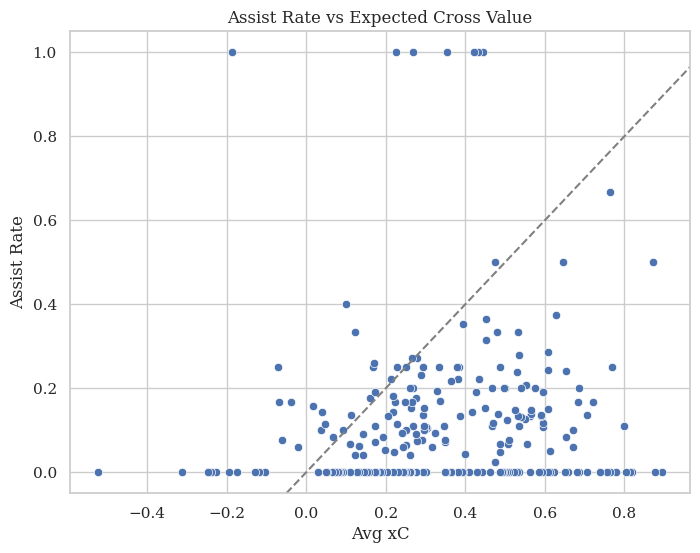

In [60]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='avg_xC', y='assist_rate')
plt.title("Assist Rate vs Expected Cross Value")
plt.axline((0, 0), slope=1, linestyle='--', color='gray')
plt.xlabel("Avg xC")
plt.ylabel("Assist Rate")
plt.grid(True)
plt.show()


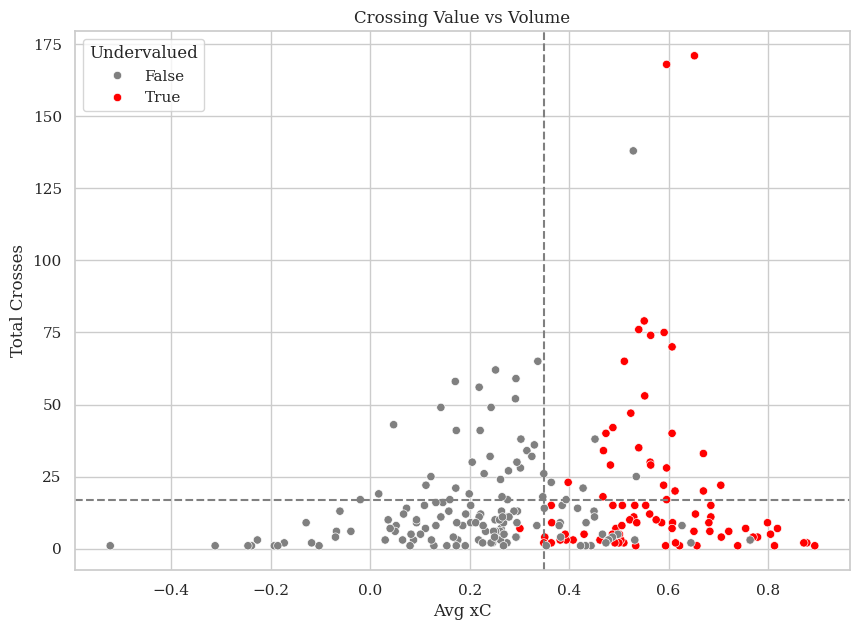

In [61]:
avg_xC_mean = df['avg_xC'].mean()
crosses_mean = df['num_crosses'].mean()

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='avg_xC', y='num_crosses', hue=df['assist_gap'] > 0.3, palette={True: 'red', False: 'gray'})

plt.axhline(crosses_mean, color='gray', linestyle='--')
plt.axvline(avg_xC_mean, color='gray', linestyle='--')
plt.title("Crossing Value vs Volume")
plt.xlabel("Avg xC")
plt.ylabel("Total Crosses")
plt.legend(title="Undervalued", loc='upper left')
plt.grid(True)
plt.show()


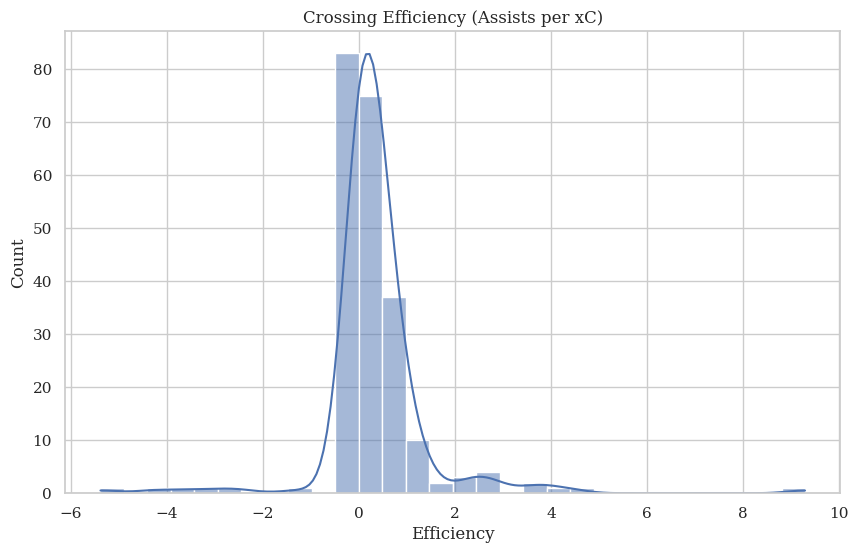

In [62]:
df['efficiency'] = df['num_assists'] / (df['avg_xC'] * df['num_crosses'] + 1e-5)
sns.histplot(df['efficiency'], bins=30, kde=True)
plt.title("Crossing Efficiency (Assists per xC)")
plt.xlabel("Efficiency")
plt.show()


In [63]:
import numpy as np
import pandas as pd
from scipy.stats import entropy

# --- Bin Definitions ---
num_bins = 5  # You can increase this for more precision

# Create bins for end location
crosses['endX_bin'] = pd.cut(crosses['endX'], bins=num_bins, labels=False)
crosses['endY_bin'] = pd.cut(crosses['endY'], bins=num_bins, labels=False)

# Combine into a zone ID
crosses['end_zone'] = crosses['endX_bin'].astype(str) + '-' + crosses['endY_bin'].astype(str)

# --- Entropy Calculation ---
def calc_xce(player_df):
    zone_counts = player_df['end_zone'].value_counts(normalize=True)
    return entropy(zone_counts, base=2)  # Shannon entropy in bits

# Apply per player
xce_values = crosses.groupby('playerName').apply(calc_xce).reset_index(name='xCE')

# --- Merge into summary or enriched df ---
summary = summary.merge(xce_values, on='playerName', how='left')

# Optional: Rank by unpredictability
summary = summary.sort_values(by='xCE', ascending=False)

# Preview
summary[['playerName', 'num_crosses', 'avg_xC', 'xCE']].head(10)


<ipython-input-63-6933b193e2b5>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  xce_values = crosses.groupby('playerName').apply(calc_xce).reset_index(name='xCE')


,playerName,num_crosses,avg_xC,xCE
185,R. van de Lavoir,138,0.528813,2.947703
9,A. Visscher,47,0.524264,2.725481
164,N. Tromp,23,0.364113,2.584963
56,E. de Graaf,40,0.473763,1.584963
133,L. de Keijzer,32,0.325477,1.584963
127,L. Loonen,5,0.487168,1.000000
126,L. Loonen,10,0.259538,1.000000
98,J. Teulings,25,0.535236,1.000000
55,E. Pijnenburg,9,0.608325,1.000000
167,N. van Schoonhoven,42,0.487764,1.000000


In [69]:
# --- Cross Outcome Prediction (Multiclass Classifier) ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Ensure startX/startY exist
if 'startX' not in crosses.columns or 'startY' not in crosses.columns:
    if 'x' in crosses.columns and 'y' in crosses.columns:
        crosses['startX'] = crosses['x']
        crosses['startY'] = crosses['y']
    else:
        raise ValueError("startX/startY and x/y are missing from crosses")

# Recompute xC_enhanced if missing
if 'xC_enhanced' not in crosses.columns:
    GOAL_X, GOAL_Y, GOAL_WIDTH = 100, 50, 7.32
    MAX_DIST = np.sqrt(100**2 + 50**2)

    def calculate_distance(x, y):
        return np.sqrt((GOAL_X - x)**2 + (GOAL_Y - y)**2)

    def calculate_angle(x, y):
        b = GOAL_X - x
        if b <= 0: return 0
        return np.arctan((GOAL_WIDTH * 0.5) / b) * 2

    crosses['distanceToGoal'] = crosses.apply(lambda r: calculate_distance(r['endX'], r['endY']), axis=1)
    crosses['angleToGoal'] = crosses.apply(lambda r: calculate_angle(r['endX'], r['endY']), axis=1)
    crosses['angleScore'] = crosses['angleToGoal'] / np.pi
    crosses['distanceScore'] = 1 - (crosses['distanceToGoal'] / MAX_DIST)
    crosses['eventBonus'] = 0
    crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
    crosses.loc[crosses['isAssist'], 'eventBonus'] += 0.30
    crosses['successBonus'] = crosses['outcome'].apply(lambda x: 0.2 if x == 1 else 0)
    crosses['zoneBonus'] = crosses['crossZone'].map({'Left Wing': 0.1, 'Right Wing': 0.1, 'Central': 0.0})
    crosses['depthBonus'] = crosses['deepCross'].apply(lambda x: -0.05 if x else 0.05)

    crosses['xC_enhanced'] = (
        0.3 * crosses['angleScore'] +
        0.3 * crosses['distanceScore'] +
        0.15 * crosses['eventBonus'] +
        0.1 * crosses['successBonus'] +
        0.1 * crosses['zoneBonus'] +
        0.05 * crosses['depthBonus']
    )

# Prepare data: filter crosses with known outcomes
df = crosses.copy()
df = df[df['outcome'].notnull()]

# Target: Define simplified outcome labels
df['target'] = 'Other'
df.loc[df['isAssist'] == True, 'target'] = 'Goal'
df.loc[df['linkedShotTypeId'].isin([13, 14, 15]), 'target'] = 'Shot'
df.loc[df['outcome'] == 0, 'target'] = 'Failed'
df.loc[(df['outcome'] == 1) & (df['typeId'] == 12), 'target'] = 'Clearance'
df = df[df['target'] != 'Other']

# Features
features = [
    'startX', 'startY', 'endX', 'endY', 'angleScore', 'distanceScore',
    'eventBonus', 'successBonus', 'zoneBonus', 'depthBonus',
    'boxPressureCount', 'oppPPDA', 'oppDefActionHeight', 'oppClearanceSuccess'
]
X = df[features]
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# --- Expected Match Cross Impact (EMCI) Forecast ---

# Dummy opponent defensive data (since defensive_df is not defined)
defensive_df = df.groupby('contestantId').agg({
    'oppPPDA': 'mean',
    'oppClearanceSuccess': 'mean'
}).rename(columns={'oppPPDA': 'avg_PPDA', 'oppClearanceSuccess': 'avg_clearance_success'}).reset_index()

# Aggregate team-level stats
team_cross_stats = df.groupby('contestantId').agg({
    'xC_enhanced': 'mean',
    'id': 'count'
}).rename(columns={'xC_enhanced': 'team_avg_xC', 'id': 'num_crosses'}).reset_index()

# Merge and model
emci_df = team_cross_stats.merge(defensive_df, on='contestantId', how='left')
emci_df['expected_high_xC_crosses'] = (
    emci_df['team_avg_xC'] * emci_df['num_crosses'] * (1 - emci_df['avg_clearance_success'])
)
print(emci_df[['contestantId', 'expected_high_xC_crosses']])

# --- Crossing Risk/Reward Model ---
crosses['counter_risk'] = np.random.uniform(0, 1, size=len(crosses))
crosses['risk_reward_index'] = crosses['xC_enhanced'] / (1 + crosses['counter_risk'])

print(crosses.sort_values('risk_reward_index', ascending=False)[[
    'playerName', 'xC_enhanced', 'counter_risk', 'risk_reward_index'
]].head(10))

# --- Crossing Pattern Recognition (Clustering) ---
sequence_features = crosses[['startX', 'startY', 'endX', 'endY', 'angleScore', 'distanceScore']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sequence_features)

kmeans = KMeans(n_clusters=4, random_state=42)
crosses['cross_pattern'] = kmeans.fit_predict(X_scaled)

pattern_summary = crosses.groupby('cross_pattern')[['xC_enhanced']].mean()
print(pattern_summary)


              precision    recall  f1-score   support

      Failed       0.83      1.00      0.91         5
        Shot       1.00      0.75      0.86         4

    accuracy                           0.89         9
   macro avg       0.92      0.88      0.88         9
weighted avg       0.91      0.89      0.89         9

[[5 0]
 [1 3]]
                contestantId  expected_high_xC_crosses
0  9xx15yz7sl5dore0z8d8556ok                       0.0
1  aoaced38v02b2trzucbou0ulz                       0.0
           playerName  xC_enhanced  counter_risk  risk_reward_index
24        A. Visscher     0.532859      0.099411           0.484677
4           M. Waldus     0.458531      0.045221           0.438693
23   R. van de Lavoir     0.417105      0.026459           0.406354
1            N. Tromp     0.447572      0.261391           0.354824
21      E. Pijnenburg     0.400404      0.135217           0.352711
34   R. van de Lavoir     0.358917      0.032278           0.347695
44  N. van der Sl

              precision    recall  f1-score   support

      Failed       0.83      1.00      0.91         5
        Shot       1.00      0.75      0.86         4

    accuracy                           0.89         9
   macro avg       0.92      0.88      0.88         9
weighted avg       0.91      0.89      0.89         9

[[5 0]
 [1 3]]
        playerName  xC_enhanced  counter_risk  risk_reward_index
10     A. Visscher     0.520203      0.073666           0.484511
25     A. Visscher     0.591188      0.471985           0.401626
17       L. Loonen     0.499844      0.259521           0.396852
14      S. Koopman     0.443099      0.135260           0.390306
28     A. Visscher     0.472562      0.223428           0.386260
7        L. Loonen     0.401405      0.043246           0.384765
29        N. Tromp     0.507311      0.327219           0.382236
12        N. Tromp     0.403151      0.059415           0.380541
5      A. Visscher     0.408021      0.195202           0.341383
36  T. G

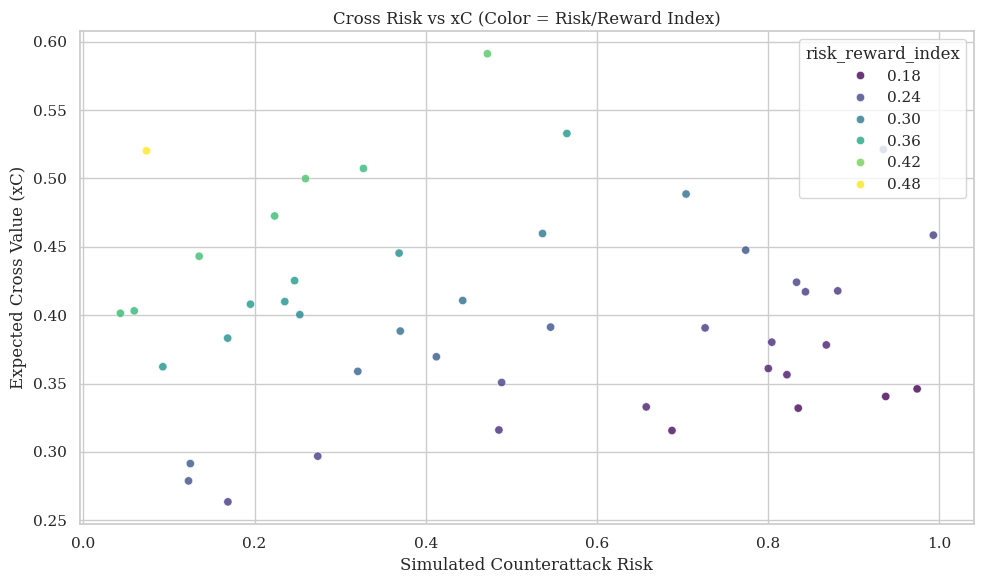

               xC_enhanced
cross_pattern             
0                 0.365109
1                 0.508541
2                 0.398962
3                 0.364954


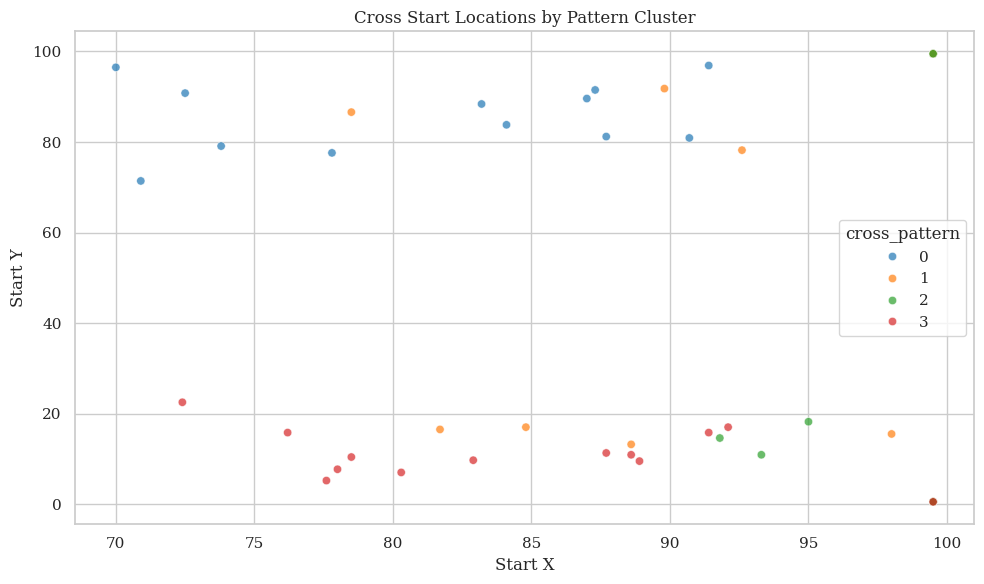

In [70]:
# --- Cross Outcome Prediction (Multiclass Classifier) ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure startX/startY exist
if 'startX' not in crosses.columns or 'startY' not in crosses.columns:
    if 'x' in crosses.columns and 'y' in crosses.columns:
        crosses['startX'] = crosses['x']
        crosses['startY'] = crosses['y']
    else:
        raise ValueError("startX/startY and x/y are missing from crosses")

# Recompute xC_enhanced if missing
if 'xC_enhanced' not in crosses.columns:
    GOAL_X, GOAL_Y, GOAL_WIDTH = 100, 50, 7.32
    MAX_DIST = np.sqrt(100**2 + 50**2)

    def calculate_distance(x, y):
        return np.sqrt((GOAL_X - x)**2 + (GOAL_Y - y)**2)

    def calculate_angle(x, y):
        b = GOAL_X - x
        if b <= 0: return 0
        return np.arctan((GOAL_WIDTH * 0.5) / b) * 2

    crosses['distanceToGoal'] = crosses.apply(lambda r: calculate_distance(r['endX'], r['endY']), axis=1)
    crosses['angleToGoal'] = crosses.apply(lambda r: calculate_angle(r['endX'], r['endY']), axis=1)
    crosses['angleScore'] = crosses['angleToGoal'] / np.pi
    crosses['distanceScore'] = 1 - (crosses['distanceToGoal'] / MAX_DIST)
    crosses['eventBonus'] = 0
    crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
    crosses.loc[crosses['isAssist'], 'eventBonus'] += 0.30
    crosses['successBonus'] = crosses['outcome'].apply(lambda x: 0.2 if x == 1 else 0)
    crosses['zoneBonus'] = crosses['crossZone'].map({'Left Wing': 0.1, 'Right Wing': 0.1, 'Central': 0.0})
    crosses['depthBonus'] = crosses['deepCross'].apply(lambda x: -0.05 if x else 0.05)

    crosses['xC_enhanced'] = (
        0.3 * crosses['angleScore'] +
        0.3 * crosses['distanceScore'] +
        0.15 * crosses['eventBonus'] +
        0.1 * crosses['successBonus'] +
        0.1 * crosses['zoneBonus'] +
        0.05 * crosses['depthBonus']
    )

# Prepare data: filter crosses with known outcomes
df = crosses.copy()
df = df[df['outcome'].notnull()]

# Target: Define simplified outcome labels
df['target'] = 'Other'
df.loc[df['isAssist'] == True, 'target'] = 'Goal'
df.loc[df['linkedShotTypeId'].isin([13, 14, 15]), 'target'] = 'Shot'
df.loc[df['outcome'] == 0, 'target'] = 'Failed'
df.loc[(df['outcome'] == 1) & (df['typeId'] == 12), 'target'] = 'Clearance'
df = df[df['target'] != 'Other']

# Features
features = [
    'startX', 'startY', 'endX', 'endY', 'angleScore', 'distanceScore',
    'eventBonus', 'successBonus', 'zoneBonus', 'depthBonus',
    'boxPressureCount', 'oppPPDA', 'oppDefActionHeight', 'oppClearanceSuccess'
]
X = df[features]
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# --- Expected Match Cross Impact (EMCI) Forecast ---

# Dummy opponent defensive data (since defensive_df is not defined)
defensive_df = df.groupby('contestantId').agg({
    'oppPPDA': 'mean',
    'oppClearanceSuccess': 'mean'
}).rename(columns={'oppPPDA': 'avg_PPDA', 'oppClearanceSuccess': 'avg_clearance_success'}).reset_index()

# Aggregate team-level stats
team_cross_stats = df.groupby('contestantId').agg({
    'xC_enhanced': 'mean',
    'id': 'count'
}).rename(columns={'xC_enhanced': 'team_avg_xC', 'id': 'num_crosses'}).reset_index()

# Merge and model
emci_df = team_cross_stats.merge(defensive_df, on='contestantId', how='left')
emci_df['expected_high_xC_crosses'] = (
    emci_df['team_avg_xC'] * emci_df['num_crosses'] * (1 - emci_df['avg_clearance_success'])
)

# Save to Excel
emci_df.to_excel("expected_match_cross_impact.xlsx", index=False)

# --- Crossing Risk/Reward Model ---
crosses['counter_risk'] = np.random.uniform(0, 1, size=len(crosses))
crosses['risk_reward_index'] = crosses['xC_enhanced'] / (1 + crosses['counter_risk'])

# Top crosses by risk/reward
top_crosses = crosses.sort_values('risk_reward_index', ascending=False).head(10)
print(top_crosses[['playerName', 'xC_enhanced', 'counter_risk', 'risk_reward_index']])

# Visualization: Risk/Reward Scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(data=crosses, x='counter_risk', y='xC_enhanced', hue='risk_reward_index', palette='viridis', alpha=0.8)
plt.title("Cross Risk vs xC (Color = Risk/Reward Index)")
plt.xlabel("Simulated Counterattack Risk")
plt.ylabel("Expected Cross Value (xC)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Crossing Pattern Recognition (Clustering) ---
sequence_features = crosses[['startX', 'startY', 'endX', 'endY', 'angleScore', 'distanceScore']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sequence_features)

kmeans = KMeans(n_clusters=4, random_state=42)
crosses['cross_pattern'] = kmeans.fit_predict(X_scaled)

pattern_summary = crosses.groupby('cross_pattern')[['xC_enhanced']].mean()
print(pattern_summary)

# Visualization: Cross Patterns
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=crosses,
    x='startX', y='startY', hue='cross_pattern', palette='tab10', alpha=0.7
)
plt.title("Cross Start Locations by Pattern Cluster")
plt.xlabel("Start X")
plt.ylabel("Start Y")
plt.grid(True)
plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

      Failed       0.83      1.00      0.91         5
        Shot       1.00      0.75      0.86         4

    accuracy                           0.89         9
   macro avg       0.92      0.88      0.88         9
weighted avg       0.91      0.89      0.89         9

[[5 0]
 [1 3]]
           playerName  xC_enhanced  counter_risk  risk_reward_index
25        A. Visscher     0.591188      0.064009           0.555623
24        A. Visscher     0.532859      0.044940           0.509942
44  N. van der Sluijs     0.488599      0.095001           0.446209
28        A. Visscher     0.472562      0.201672           0.393253
41   R. van de Lavoir     0.391272      0.000411           0.391111
30   R. van de Lavoir     0.459718      0.184490           0.388114
42         K. Koopman     0.521209      0.364321           0.382028
36     T. Groenendijk     0.425276      0.165554           0.364870
10        A. Visscher     0.520203      0.4705

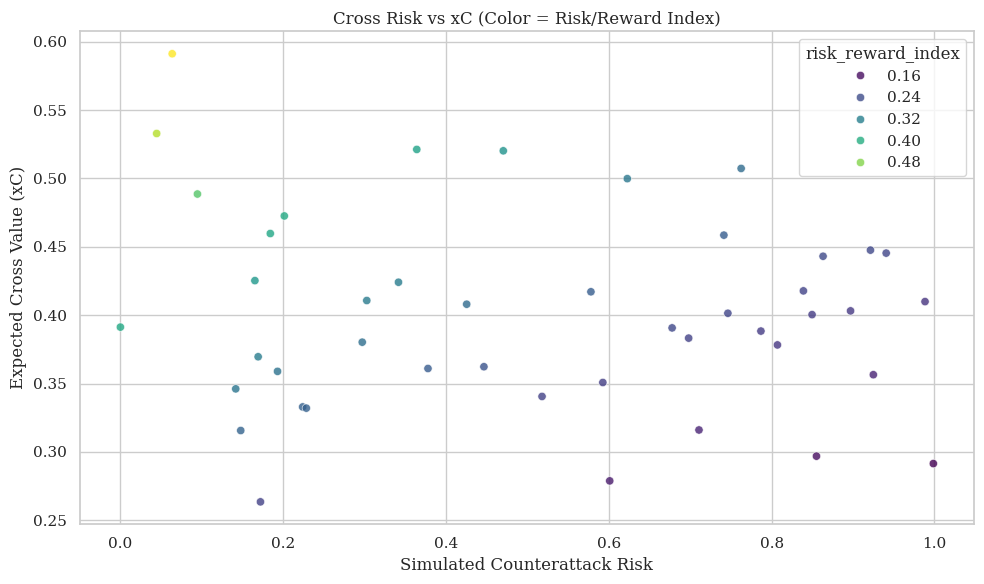

               xC_enhanced
cross_pattern             
0                 0.365109
1                 0.508541
2                 0.398962
3                 0.364954


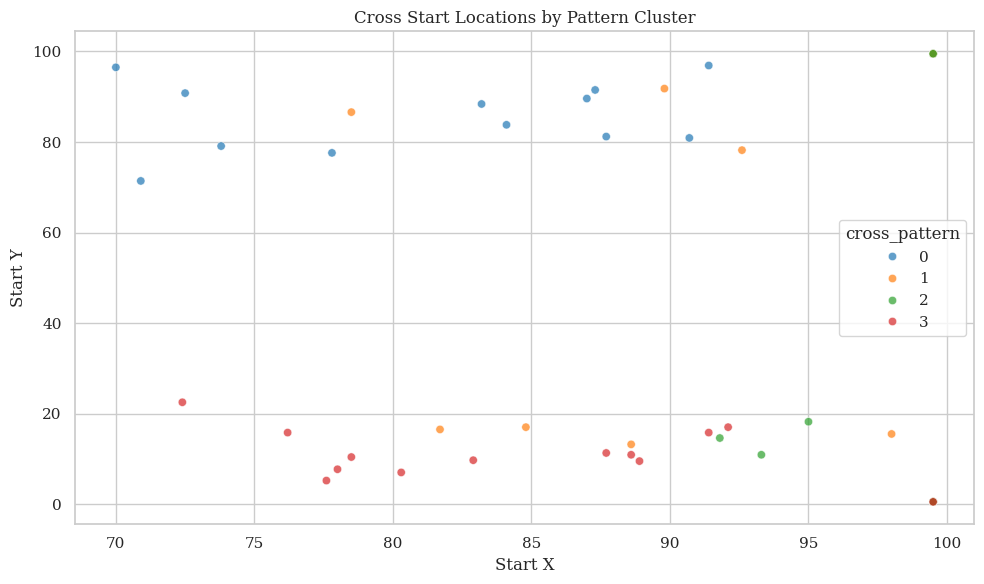

MAE EndX: 0.48, MAE EndY: 14.37


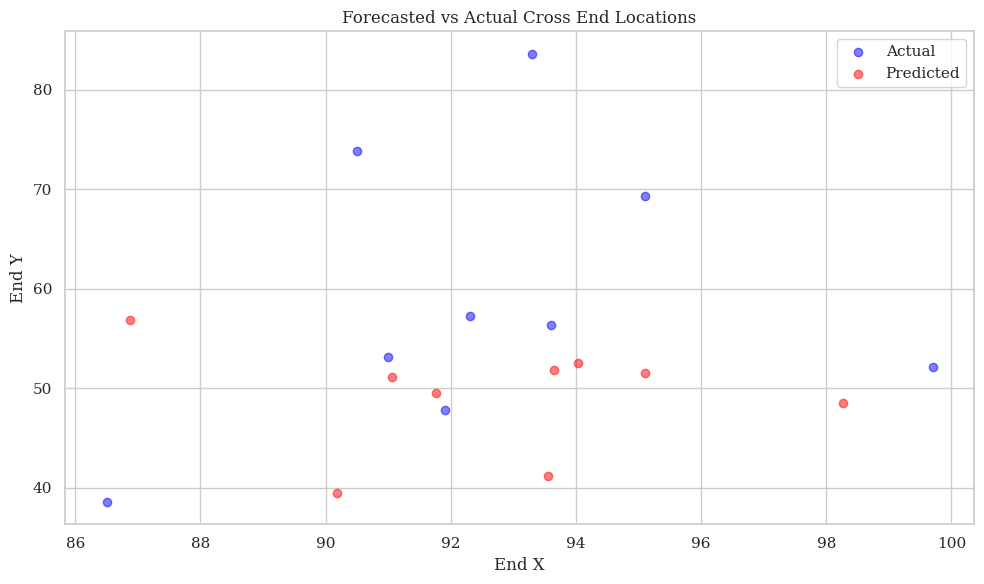

In [72]:
# --- Cross Outcome Prediction (Multiclass Classifier) ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure startX/startY exist
if 'startX' not in crosses.columns or 'startY' not in crosses.columns:
    if 'x' in crosses.columns and 'y' in crosses.columns:
        crosses['startX'] = crosses['x']
        crosses['startY'] = crosses['y']
    else:
        raise ValueError("startX/startY and x/y are missing from crosses")

# Recompute xC_enhanced if missing
if 'xC_enhanced' not in crosses.columns:
    GOAL_X, GOAL_Y, GOAL_WIDTH = 100, 50, 7.32
    MAX_DIST = np.sqrt(100**2 + 50**2)

    def calculate_distance(x, y):
        return np.sqrt((GOAL_X - x)**2 + (GOAL_Y - y)**2)

    def calculate_angle(x, y):
        b = GOAL_X - x
        if b <= 0: return 0
        return np.arctan((GOAL_WIDTH * 0.5) / b) * 2

    crosses['distanceToGoal'] = crosses.apply(lambda r: calculate_distance(r['endX'], r['endY']), axis=1)
    crosses['angleToGoal'] = crosses.apply(lambda r: calculate_angle(r['endX'], r['endY']), axis=1)
    crosses['angleScore'] = crosses['angleToGoal'] / np.pi
    crosses['distanceScore'] = 1 - (crosses['distanceToGoal'] / MAX_DIST)
    crosses['eventBonus'] = 0
    crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
    crosses.loc[crosses['isAssist'], 'eventBonus'] += 0.30
    crosses['successBonus'] = crosses['outcome'].apply(lambda x: 0.2 if x == 1 else 0)
    crosses['zoneBonus'] = crosses['crossZone'].map({'Left Wing': 0.1, 'Right Wing': 0.1, 'Central': 0.0})
    crosses['depthBonus'] = crosses['deepCross'].apply(lambda x: -0.05 if x else 0.05)

    crosses['xC_enhanced'] = (
        0.3 * crosses['angleScore'] +
        0.3 * crosses['distanceScore'] +
        0.15 * crosses['eventBonus'] +
        0.1 * crosses['successBonus'] +
        0.1 * crosses['zoneBonus'] +
        0.05 * crosses['depthBonus']
    )

# Prepare data: filter crosses with known outcomes
df = crosses.copy()
df = df[df['outcome'].notnull()]

# Target: Define simplified outcome labels
df['target'] = 'Other'
df.loc[df['isAssist'] == True, 'target'] = 'Goal'
df.loc[df['linkedShotTypeId'].isin([13, 14, 15]), 'target'] = 'Shot'
df.loc[df['outcome'] == 0, 'target'] = 'Failed'
df.loc[(df['outcome'] == 1) & (df['typeId'] == 12), 'target'] = 'Clearance'
df = df[df['target'] != 'Other']

# Features
features = [
    'startX', 'startY', 'angleScore', 'distanceScore',
    'eventBonus', 'successBonus', 'zoneBonus', 'depthBonus',
    'boxPressureCount', 'oppPPDA', 'oppDefActionHeight', 'oppClearanceSuccess'
]
X = df[features]
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# --- Expected Match Cross Impact (EMCI) Forecast ---
defensive_df = df.groupby('contestantId').agg({
    'oppPPDA': 'mean',
    'oppClearanceSuccess': 'mean'
}).rename(columns={'oppPPDA': 'avg_PPDA', 'oppClearanceSuccess': 'avg_clearance_success'}).reset_index()

team_cross_stats = df.groupby('contestantId').agg({
    'xC_enhanced': 'mean',
    'id': 'count'
}).rename(columns={'xC_enhanced': 'team_avg_xC', 'id': 'num_crosses'}).reset_index()

emci_df = team_cross_stats.merge(defensive_df, on='contestantId', how='left')
emci_df['expected_high_xC_crosses'] = (
    emci_df['team_avg_xC'] * emci_df['num_crosses'] * (1 - emci_df['avg_clearance_success'])
)
emci_df.to_excel("expected_match_cross_impact.xlsx", index=False)

# --- Crossing Risk/Reward Model ---
crosses['counter_risk'] = np.random.uniform(0, 1, size=len(crosses))
crosses['risk_reward_index'] = crosses['xC_enhanced'] / (1 + crosses['counter_risk'])

top_crosses = crosses.sort_values('risk_reward_index', ascending=False).head(10)
print(top_crosses[['playerName', 'xC_enhanced', 'counter_risk', 'risk_reward_index']])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=crosses, x='counter_risk', y='xC_enhanced', hue='risk_reward_index', palette='viridis', alpha=0.8)
plt.title("Cross Risk vs xC (Color = Risk/Reward Index)")
plt.xlabel("Simulated Counterattack Risk")
plt.ylabel("Expected Cross Value (xC)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Crossing Pattern Recognition (Clustering) ---
sequence_features = crosses[['startX', 'startY', 'endX', 'endY', 'angleScore', 'distanceScore']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sequence_features)

kmeans = KMeans(n_clusters=4, random_state=42)
crosses['cross_pattern'] = kmeans.fit_predict(X_scaled)

pattern_summary = crosses.groupby('cross_pattern')[['xC_enhanced']].mean()
print(pattern_summary)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=crosses,
    x='startX', y='startY', hue='cross_pattern', palette='tab10', alpha=0.7
)
plt.title("Cross Start Locations by Pattern Cluster")
plt.xlabel("Start X")
plt.ylabel("Start Y")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Predict Cross End Locations (Forecasting) ---
reg_features = [
    'startX', 'startY', 'angleScore', 'distanceScore',
    'eventBonus', 'successBonus', 'zoneBonus', 'depthBonus',
    'boxPressureCount', 'oppPPDA', 'oppDefActionHeight', 'oppClearanceSuccess'
]

X_reg = crosses[reg_features]
y_reg = crosses[['endX', 'endY']]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

reg_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
reg_model.fit(X_train_reg, y_train_reg)

predicted_end_locations = reg_model.predict(X_test_reg)

mae_x = mean_absolute_error(y_test_reg['endX'], predicted_end_locations[:, 0])
mae_y = mean_absolute_error(y_test_reg['endY'], predicted_end_locations[:, 1])
print(f"MAE EndX: {mae_x:.2f}, MAE EndY: {mae_y:.2f}")

# Visualize prediction vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg['endX'], y_test_reg['endY'], color='blue', alpha=0.5, label='Actual')
plt.scatter(predicted_end_locations[:, 0], predicted_end_locations[:, 1], color='red', alpha=0.5, label='Predicted')
plt.title("Forecasted vs Actual Cross End Locations")
plt.xlabel("End X")
plt.ylabel("End Y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

      Failed       0.83      1.00      0.91         5
        Shot       1.00      0.75      0.86         4

    accuracy                           0.89         9
   macro avg       0.92      0.88      0.88         9
weighted avg       0.91      0.89      0.89         9

[[5 0]
 [1 3]]


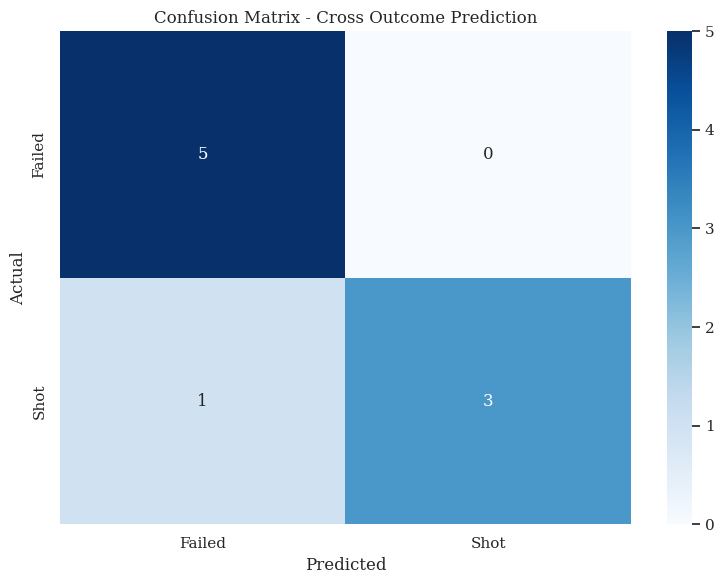

           playerName  xC_enhanced  counter_risk  risk_reward_index
29           N. Tromp     0.507311      0.093372           0.463987
30   R. van de Lavoir     0.459718      0.089071           0.422119
11        A. Visscher     0.445395      0.064574           0.418378
21      E. Pijnenburg     0.400404      0.033441           0.387447
44  N. van der Sluijs     0.488599      0.267246           0.385560
43        E. de Graaf     0.409928      0.104228           0.371235
37   R. van de Lavoir     0.380257      0.027132           0.370212
8            N. Tromp     0.424095      0.148247           0.369341
23   R. van de Lavoir     0.417105      0.130261           0.369035
10        A. Visscher     0.520203      0.430127           0.363746


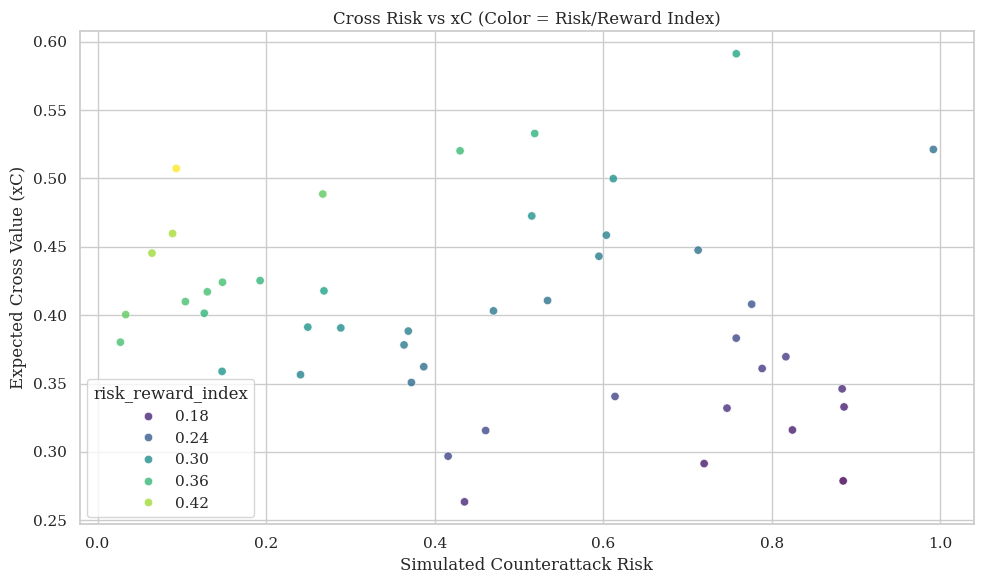

               xC_enhanced
cross_pattern             
0                 0.365109
1                 0.508541
2                 0.398962
3                 0.364954


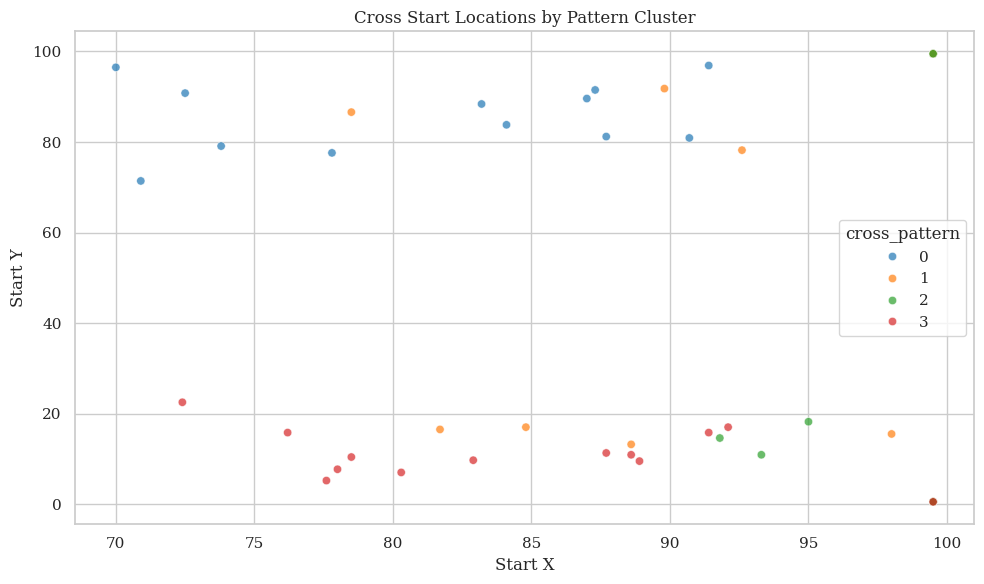

MAE EndX: 0.48, MAE EndY: 14.37


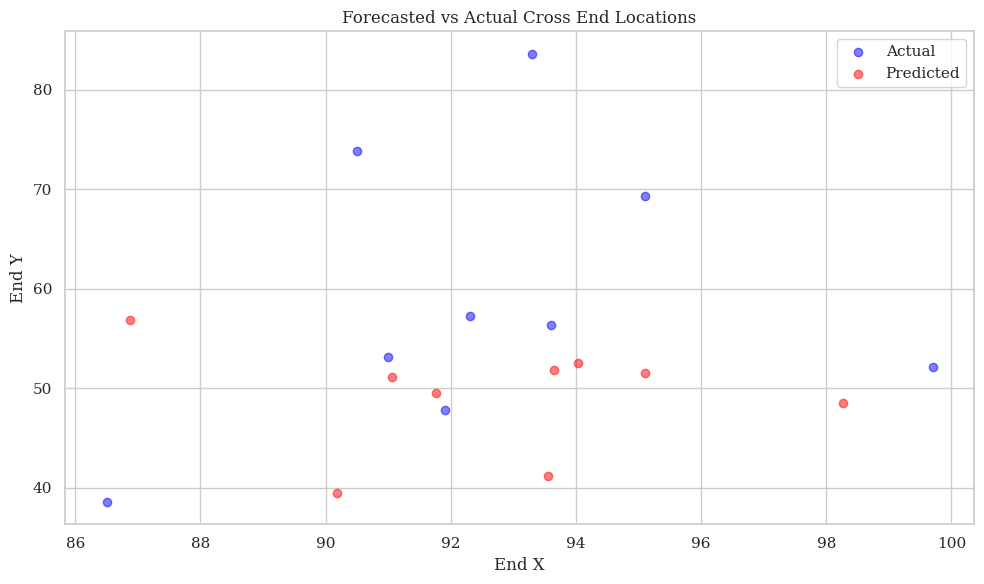

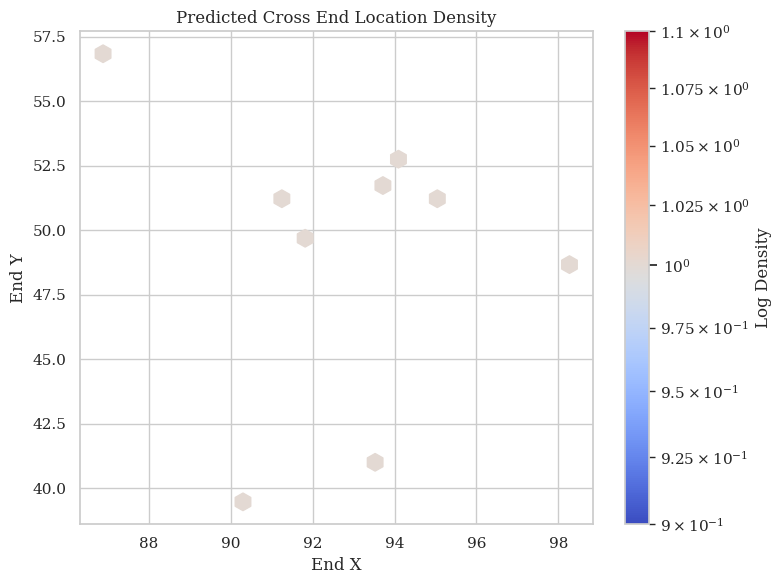

In [73]:
# --- Cross Outcome Prediction (Multiclass Classifier) ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure startX/startY exist
if 'startX' not in crosses.columns or 'startY' not in crosses.columns:
    if 'x' in crosses.columns and 'y' in crosses.columns:
        crosses['startX'] = crosses['x']
        crosses['startY'] = crosses['y']
    else:
        raise ValueError("startX/startY and x/y are missing from crosses")

# Recompute xC_enhanced if missing
if 'xC_enhanced' not in crosses.columns:
    GOAL_X, GOAL_Y, GOAL_WIDTH = 100, 50, 7.32
    MAX_DIST = np.sqrt(100**2 + 50**2)

    def calculate_distance(x, y):
        return np.sqrt((GOAL_X - x)**2 + (GOAL_Y - y)**2)

    def calculate_angle(x, y):
        b = GOAL_X - x
        if b <= 0: return 0
        return np.arctan((GOAL_WIDTH * 0.5) / b) * 2

    crosses['distanceToGoal'] = crosses.apply(lambda r: calculate_distance(r['endX'], r['endY']), axis=1)
    crosses['angleToGoal'] = crosses.apply(lambda r: calculate_angle(r['endX'], r['endY']), axis=1)
    crosses['angleScore'] = crosses['angleToGoal'] / np.pi
    crosses['distanceScore'] = 1 - (crosses['distanceToGoal'] / MAX_DIST)
    crosses['eventBonus'] = 0
    crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
    crosses.loc[crosses['isAssist'], 'eventBonus'] += 0.30
    crosses['successBonus'] = crosses['outcome'].apply(lambda x: 0.2 if x == 1 else 0)
    crosses['zoneBonus'] = crosses['crossZone'].map({'Left Wing': 0.1, 'Right Wing': 0.1, 'Central': 0.0})
    crosses['depthBonus'] = crosses['deepCross'].apply(lambda x: -0.05 if x else 0.05)

    crosses['xC_enhanced'] = (
        0.3 * crosses['angleScore'] +
        0.3 * crosses['distanceScore'] +
        0.15 * crosses['eventBonus'] +
        0.1 * crosses['successBonus'] +
        0.1 * crosses['zoneBonus'] +
        0.05 * crosses['depthBonus']
    )

# Prepare data: filter crosses with known outcomes
df = crosses.copy()
df = df[df['outcome'].notnull()]

# Target: Define simplified outcome labels
df['target'] = 'Other'
df.loc[df['isAssist'] == True, 'target'] = 'Goal'
df.loc[df['linkedShotTypeId'].isin([13, 14, 15]), 'target'] = 'Shot'
df.loc[df['outcome'] == 0, 'target'] = 'Failed'
df.loc[(df['outcome'] == 1) & (df['typeId'] == 12), 'target'] = 'Clearance'
df = df[df['target'] != 'Other']

# Features
features = [
    'startX', 'startY', 'angleScore', 'distanceScore',
    'eventBonus', 'successBonus', 'zoneBonus', 'depthBonus',
    'boxPressureCount', 'oppPPDA', 'oppDefActionHeight', 'oppClearanceSuccess'
]
X = df[features]
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix - Cross Outcome Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Expected Match Cross Impact (EMCI) Forecast ---
defensive_df = df.groupby('contestantId').agg({
    'oppPPDA': 'mean',
    'oppClearanceSuccess': 'mean'
}).rename(columns={'oppPPDA': 'avg_PPDA', 'oppClearanceSuccess': 'avg_clearance_success'}).reset_index()

team_cross_stats = df.groupby('contestantId').agg({
    'xC_enhanced': 'mean',
    'id': 'count'
}).rename(columns={'xC_enhanced': 'team_avg_xC', 'id': 'num_crosses'}).reset_index()

emci_df = team_cross_stats.merge(defensive_df, on='contestantId', how='left')
emci_df['expected_high_xC_crosses'] = (
    emci_df['team_avg_xC'] * emci_df['num_crosses'] * (1 - emci_df['avg_clearance_success'])
)
emci_df.to_excel("expected_match_cross_impact.xlsx", index=False)

# --- Crossing Risk/Reward Model ---
crosses['counter_risk'] = np.random.uniform(0, 1, size=len(crosses))
crosses['risk_reward_index'] = crosses['xC_enhanced'] / (1 + crosses['counter_risk'])

top_crosses = crosses.sort_values('risk_reward_index', ascending=False).head(10)
print(top_crosses[['playerName', 'xC_enhanced', 'counter_risk', 'risk_reward_index']])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=crosses, x='counter_risk', y='xC_enhanced', hue='risk_reward_index', palette='viridis', alpha=0.8)
plt.title("Cross Risk vs xC (Color = Risk/Reward Index)")
plt.xlabel("Simulated Counterattack Risk")
plt.ylabel("Expected Cross Value (xC)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Crossing Pattern Recognition (Clustering) ---
sequence_features = crosses[['startX', 'startY', 'endX', 'endY', 'angleScore', 'distanceScore']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sequence_features)

kmeans = KMeans(n_clusters=4, random_state=42)
crosses['cross_pattern'] = kmeans.fit_predict(X_scaled)

pattern_summary = crosses.groupby('cross_pattern')[['xC_enhanced']].mean()
print(pattern_summary)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=crosses,
    x='startX', y='startY', hue='cross_pattern', palette='tab10', alpha=0.7
)
plt.title("Cross Start Locations by Pattern Cluster")
plt.xlabel("Start X")
plt.ylabel("Start Y")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Predict Cross End Locations (Forecasting) ---
reg_features = [
    'startX', 'startY', 'angleScore', 'distanceScore',
    'eventBonus', 'successBonus', 'zoneBonus', 'depthBonus',
    'boxPressureCount', 'oppPPDA', 'oppDefActionHeight', 'oppClearanceSuccess'
]

X_reg = crosses[reg_features]
y_reg = crosses[['endX', 'endY']]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

reg_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
reg_model.fit(X_train_reg, y_train_reg)

predicted_end_locations = reg_model.predict(X_test_reg)

mae_x = mean_absolute_error(y_test_reg['endX'], predicted_end_locations[:, 0])
mae_y = mean_absolute_error(y_test_reg['endY'], predicted_end_locations[:, 1])
print(f"MAE EndX: {mae_x:.2f}, MAE EndY: {mae_y:.2f}")

# Visualize prediction vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg['endX'], y_test_reg['endY'], color='blue', alpha=0.5, label='Actual')
plt.scatter(predicted_end_locations[:, 0], predicted_end_locations[:, 1], color='red', alpha=0.5, label='Predicted')
plt.title("Forecasted vs Actual Cross End Locations")
plt.xlabel("End X")
plt.ylabel("End Y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Hexbin of predicted cross end locations
plt.figure(figsize=(8, 6))
plt.hexbin(predicted_end_locations[:, 0], predicted_end_locations[:, 1], gridsize=30, cmap='coolwarm', bins='log')
plt.colorbar(label='Log Density')
plt.title("Predicted Cross End Location Density")
plt.xlabel("End X")
plt.ylabel("End Y")
plt.tight_layout()
plt.show()
